## Checks

In [ ]:
%load_ext autoreload
%autoreload 2

# Lots of small/large numbers involved in these calculations, so
# need to use 64-bit mode
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

from binary import *
import numpy as np, matplotlib.pyplot as plt

Text(0, 0.5, '$\\Phi_V - \\Phi$ [rad]')

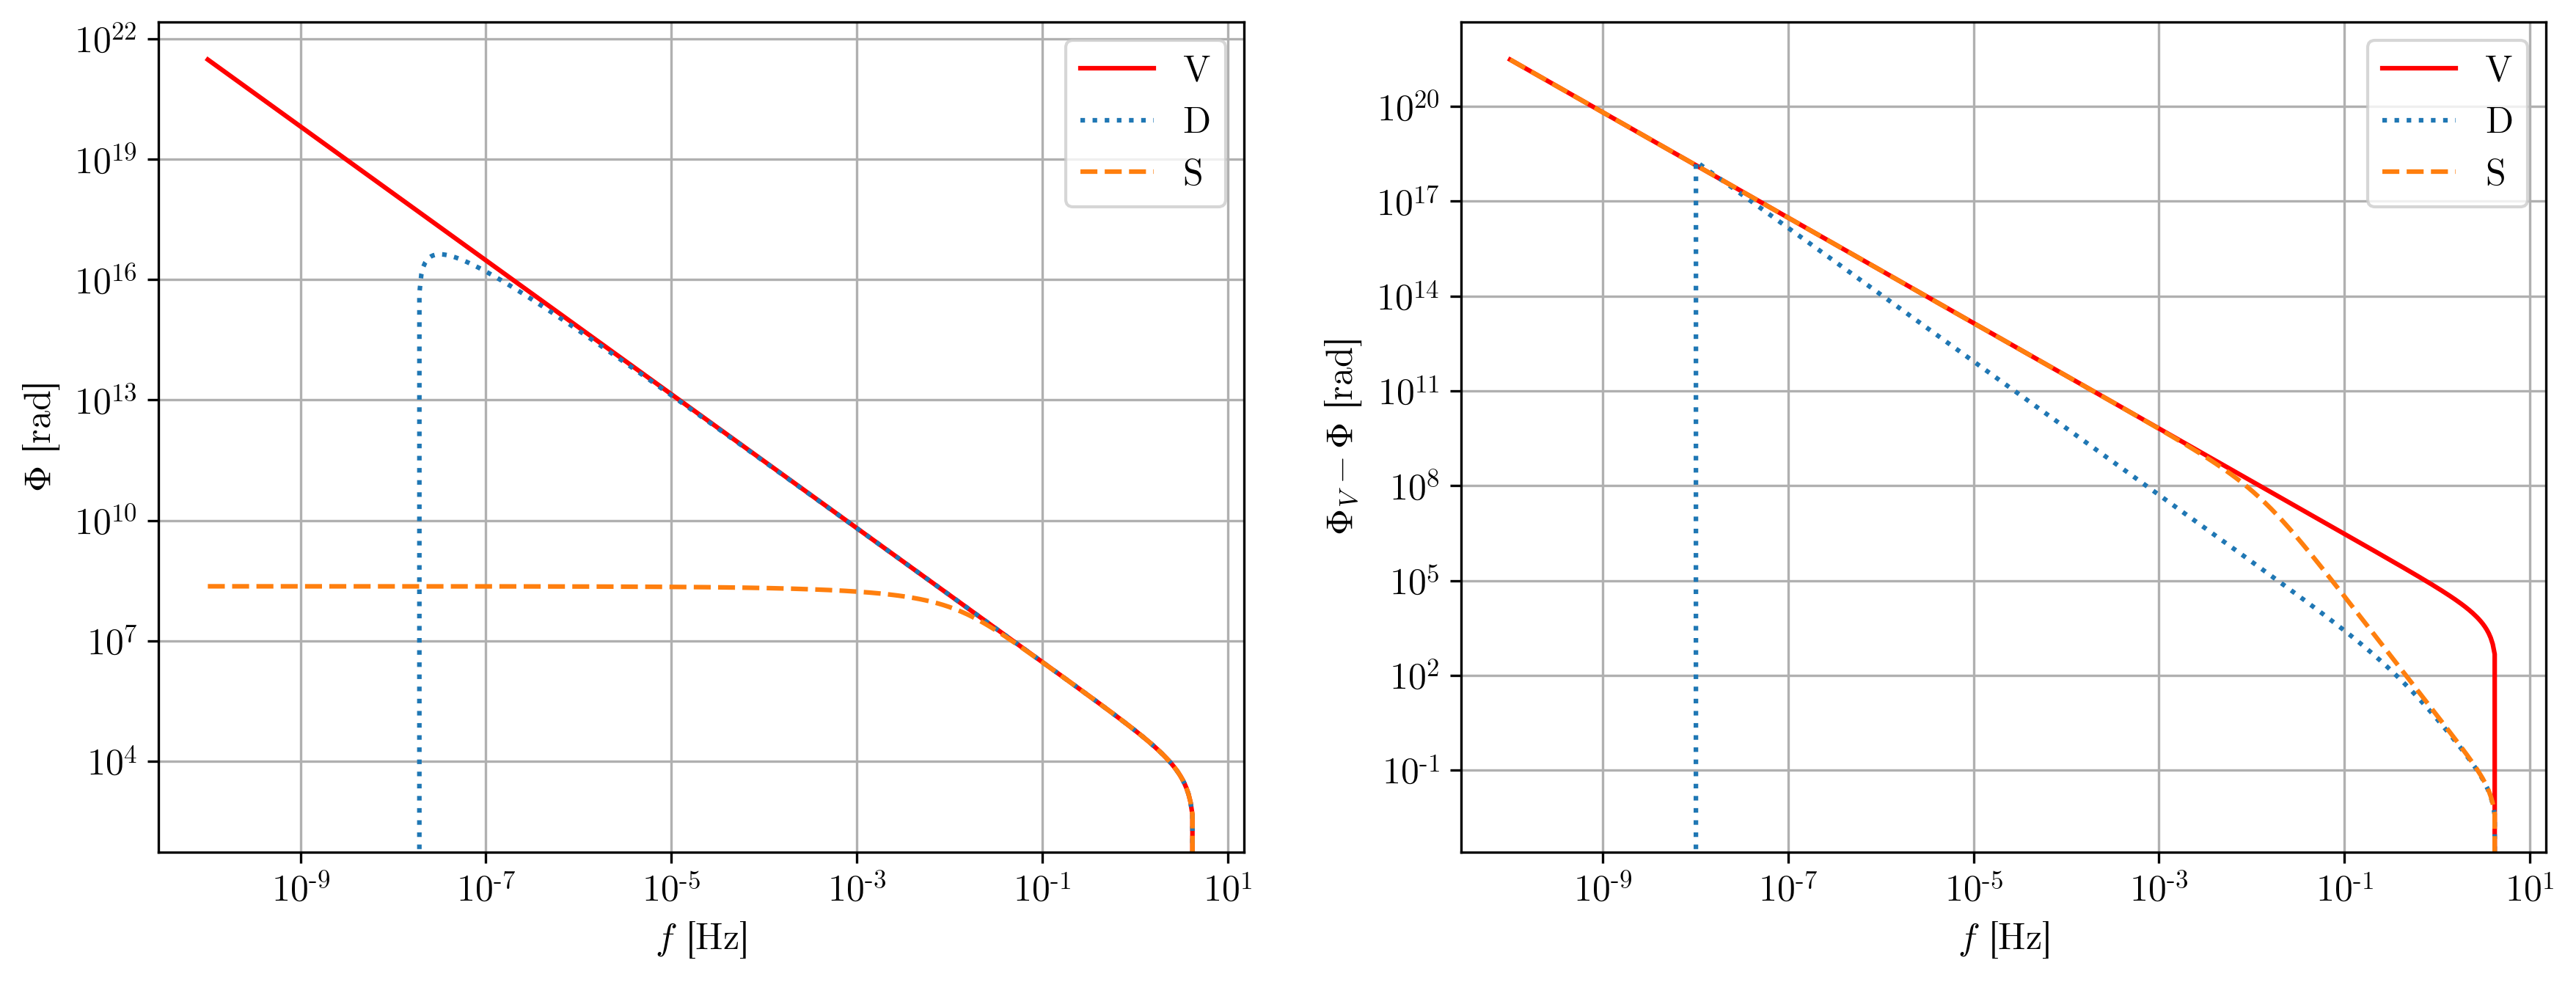

In [40]:
f = np.geomspace(1e-10, f_c, 500)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.loglog(f, vb.Phi_to_c(f, f_c), "r", label="V")
ax.loglog(f, dd.Phi_to_c(f, f_c), ":", label="D")
ax.loglog(f, sd.Phi_to_c(f, f_c), "--", label="S")
ax.legend()
ax.grid()
ax.set_xlabel(r"$f$ [Hz]")
ax.set_ylabel(r"$\Phi$ [rad]")

ax = axes[1]
ax.loglog(f, vb.Phi_to_c(f, f_c), "r", label="V")
ax.loglog(f, vb.Phi_to_c(f, f_c) - dd.Phi_to_c(f, f_c), ":", label="D")
ax.loglog(f, vb.Phi_to_c(f, f_c) - sd.Phi_to_c(f, f_c), "--", label="S")
ax.legend()
ax.grid()
ax.set_xlabel(r"$f$ [Hz]")
ax.set_ylabel(r"$\Phi_V - \Phi$ [rad]")

## Log likelihood (jax)

In [1]:
%load_ext autoreload
%autoreload 2

# Lots of small/large numbers involved in these calculations, so
# need to use 64-bit mode
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

from binary import *
import numpy as np, matplotlib.pyplot as plt

In [2]:
m_1 = 1e3 * MSUN
m_2 = 1 * MSUN
rho_s = 226 * MSUN / PC**3
gamma_s = 7 / 3
f_c = get_f_isco(m_1)

vb = VacuumBinary.make(m_1, m_2)
sd = StaticDress.make(m_1, m_2, rho_s, gamma_s)
dd = DynamicDress.make(m_1, m_2, rho_s, gamma_s)

# [q, \tilde{t}_c] = [6.45246955e-04, -1.98186232e+02]
dd_alt = DynamicDress(
    gamma_s=2.27843666,
    c_f=7.38694332e-05,
    M_chirp=1.58499392e+01 * MSUN,
    q=6.45246955e-04,
    Phi_c=0.,
    tT_c=-1.98186232e+02,
    dL_iota=dd.dL_iota
)

In [3]:
def S_n_LISA(f):
    return 1 / f**14 * 1.80654e-17 * (0.000606151 + f**2) * (3.6864e-76 + 3.6e-37 * f**8 + 2.25e-30 * f**10 + 8.66941e-21 * f**14)

def loglikelihood(
    dd_1: Binary, dd_2: Binary, f_l, f_c, n=500, n_same=20, S_n=S_n_LISA
):
    fs_same = jnp.geomspace(f_l, f_c, n_same)#, dtype=jnp.float64)
    
    # Waveform magnitudes
    S_ns_same = S_n(fs_same)
    ip_11 = 4 * jnp.trapz(dd_1.amp_plus(fs_same)**2 / S_ns_same, fs_same)
    ip_22 = 4 * jnp.trapz(dd_2.amp_plus(fs_same)**2 / S_ns_same, fs_same)
    
    # Inner product of waveforms, maximizing over Phi_c by taking the absolute value
    fs = jnp.geomspace(f_l, f_c, n)#, dtype=jnp.float64)
    amp_prods = dd_1.amp_plus(fs) * dd_2.amp_plus(fs)
    dPsis = dd_1.Psi(fs, f_c) - dd_2.Psi(fs, f_c)
    S_ns = S_n(fs)
    re_ip_12 = 4 * jnp.trapz(amp_prods * jnp.cos(dPsis) / S_ns, fs)
    im_ip_12 = 4 * jnp.trapz(amp_prods * jnp.sin(dPsis) / S_ns, fs)
    ip_12 = jnp.sqrt(re_ip_12**2 + im_ip_12**2)
    
    return -1 / 2 * (ip_22 - ip_12**2 / ip_11)

In [4]:
f_l = 0.022621092492458004  # Hz
loglikelihood(dd, dd, f_l, f_c), loglikelihood(dd, dd_alt, f_l, f_c)

(DeviceArray(-8.04133601, dtype=float64),
 DeviceArray(-45.53100346, dtype=float64))

## Take two (jax)

In [4]:
%load_ext autoreload
%autoreload 2

# Lots of small/large numbers involved in these calculations, so
# need to use 64-bit mode
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
from jax import random

from binary_jax import *
from analysis_jax import *
from noise import *
import numpy as np
import matplotlib.pyplot as plt

### Basic plotting check

In [2]:
m_1 = 1e3 * MSUN
m_2 = 1 * MSUN
rho_s = 226 * MSUN / PC**3
gamma_s = 7 / 3
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1)

vb = make_vacuum_binary(m_1, m_2)
sd = make_static_dress(m_1, m_2, rho_s, gamma_s)
dd = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)

1.0 -45116.41758822682 -0.03823010985197954
1.0 -0.03823010985197953 -0.03823010985197953
0.7894736842105263 -405.17719476969205 -8.251536942039751e-06
0.7894736842105263 -8.251536942039748e-06 -8.251536942039748e-06
1.0 -45116.41758822682 -0.03823010985197954
1.0 -0.03823010985197953 -0.03823010985197953
0.7894736842105263 -405.17719476969205 -8.251536942039751e-06
0.7894736842105263 -8.251536942039748e-06 -8.251536942039748e-06


Text(0, 0.5, '$\\Phi_V - \\Phi$ [rad]')

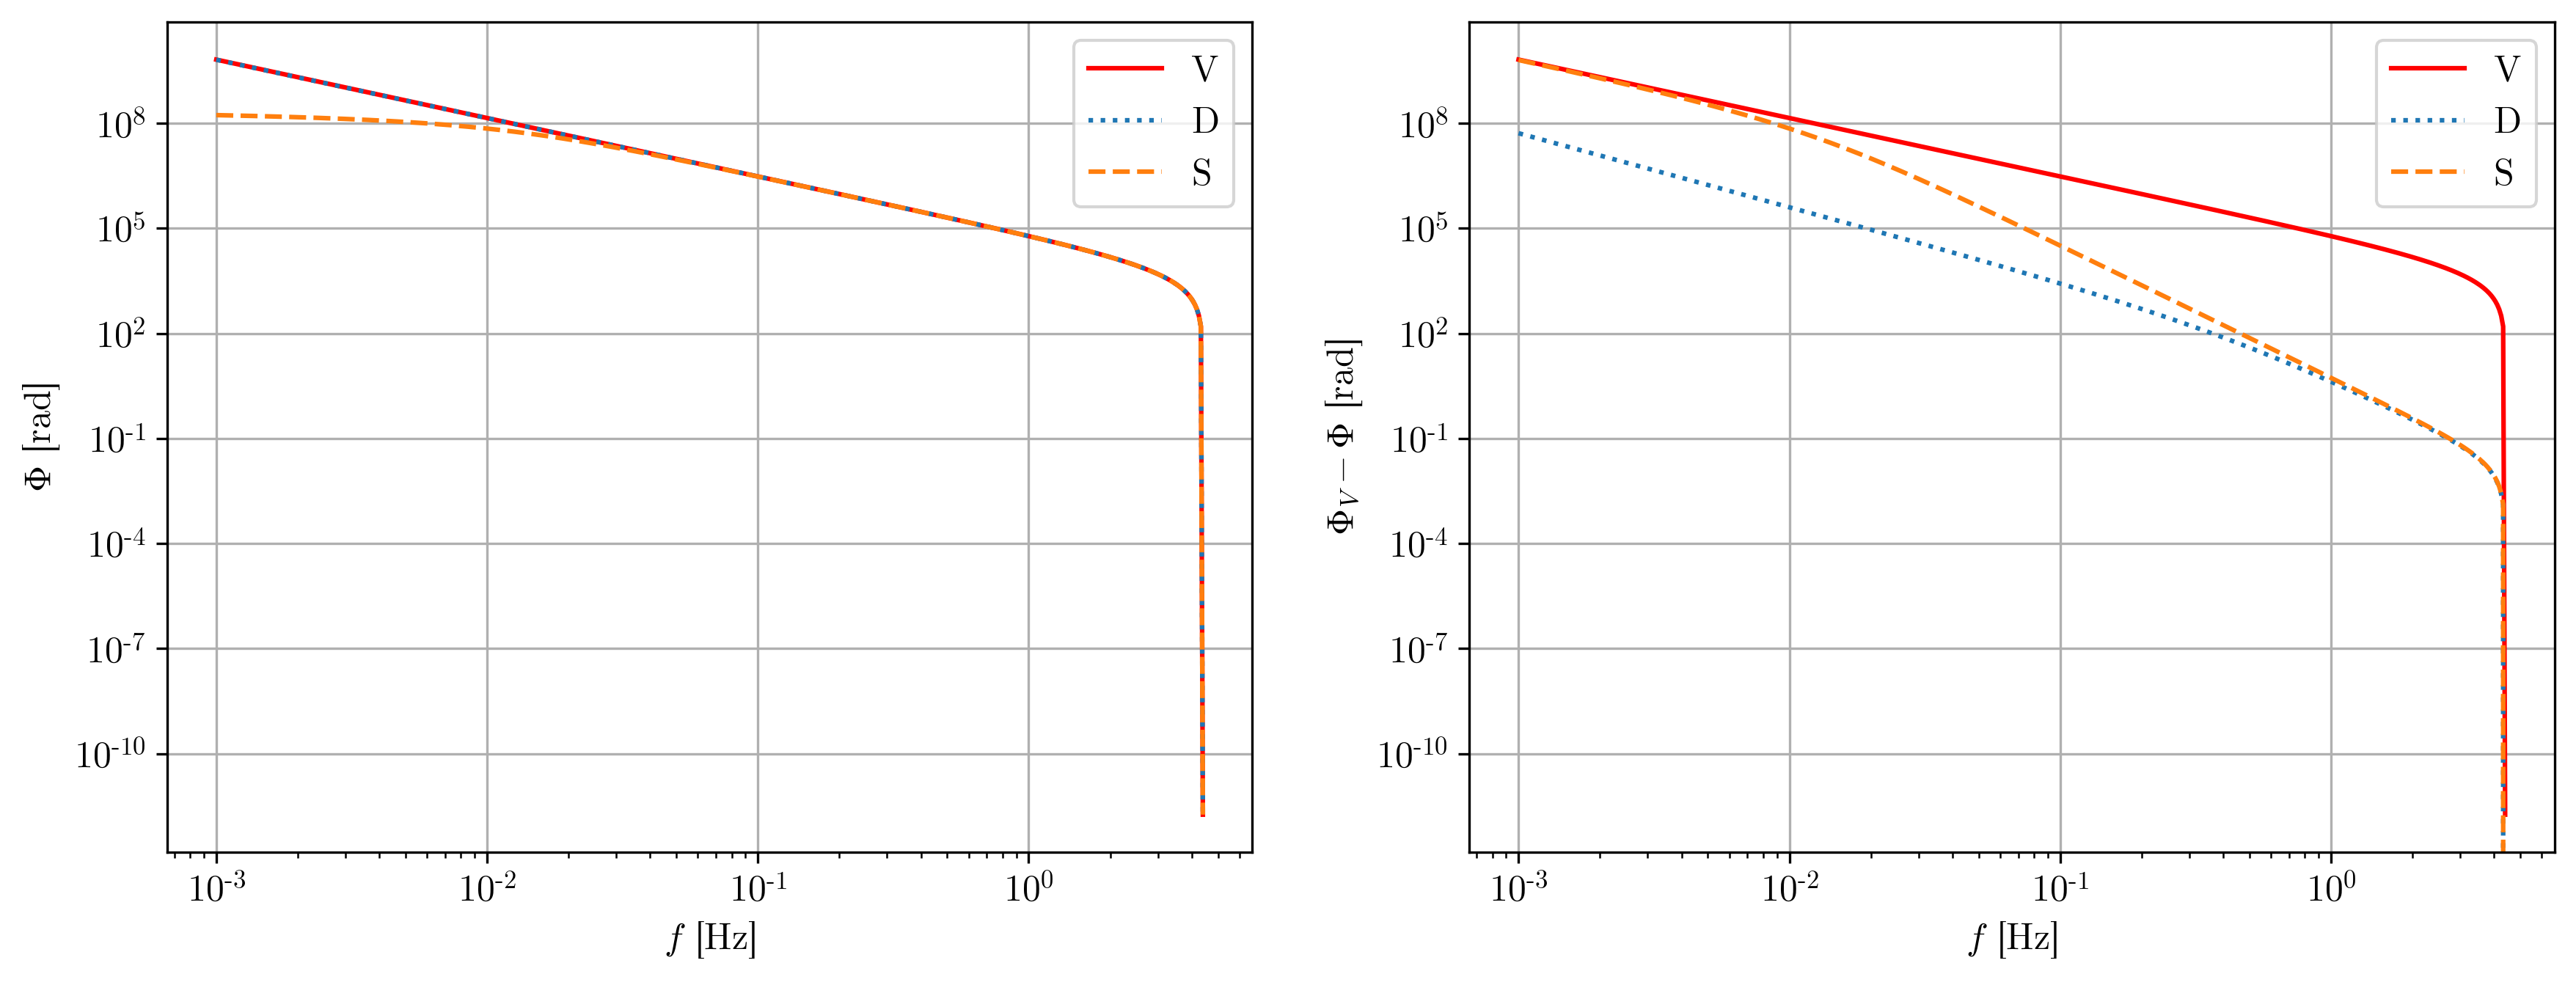

In [12]:
f = jnp.geomspace(1e-3, f_c, 500)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.loglog(f, Phi_to_c(f, f_c, vb, "v"), "r", label="V")
ax.loglog(f, Phi_to_c(f, f_c, dd, "d"), ":", label="D")
ax.loglog(f, Phi_to_c(f, f_c, sd, "s"), "--", label="S")
ax.legend()
ax.grid()
ax.set_xlabel(r"$f$ [Hz]")
ax.set_ylabel(r"$\Phi$ [rad]")

ax = axes[1]
ax.loglog(f, Phi_to_c(f, f_c, vb, "v"), "r", label="V")
ax.loglog(f, Phi_to_c(f, f_c, vb, "v") - Phi_to_c(f, f_c, dd, "d"), ":", label="D")
ax.loglog(f, Phi_to_c(f, f_c, vb, "v") - Phi_to_c(f, f_c, sd, "s"), "--", label="S")
ax.legend()
ax.grid()
ax.set_xlabel(r"$f$ [Hz]")
ax.set_ylabel(r"$\Phi_V - \Phi$ [rad]")

Text(0, 0.5, '$\\Psi_V - \\Psi$ [rad]')

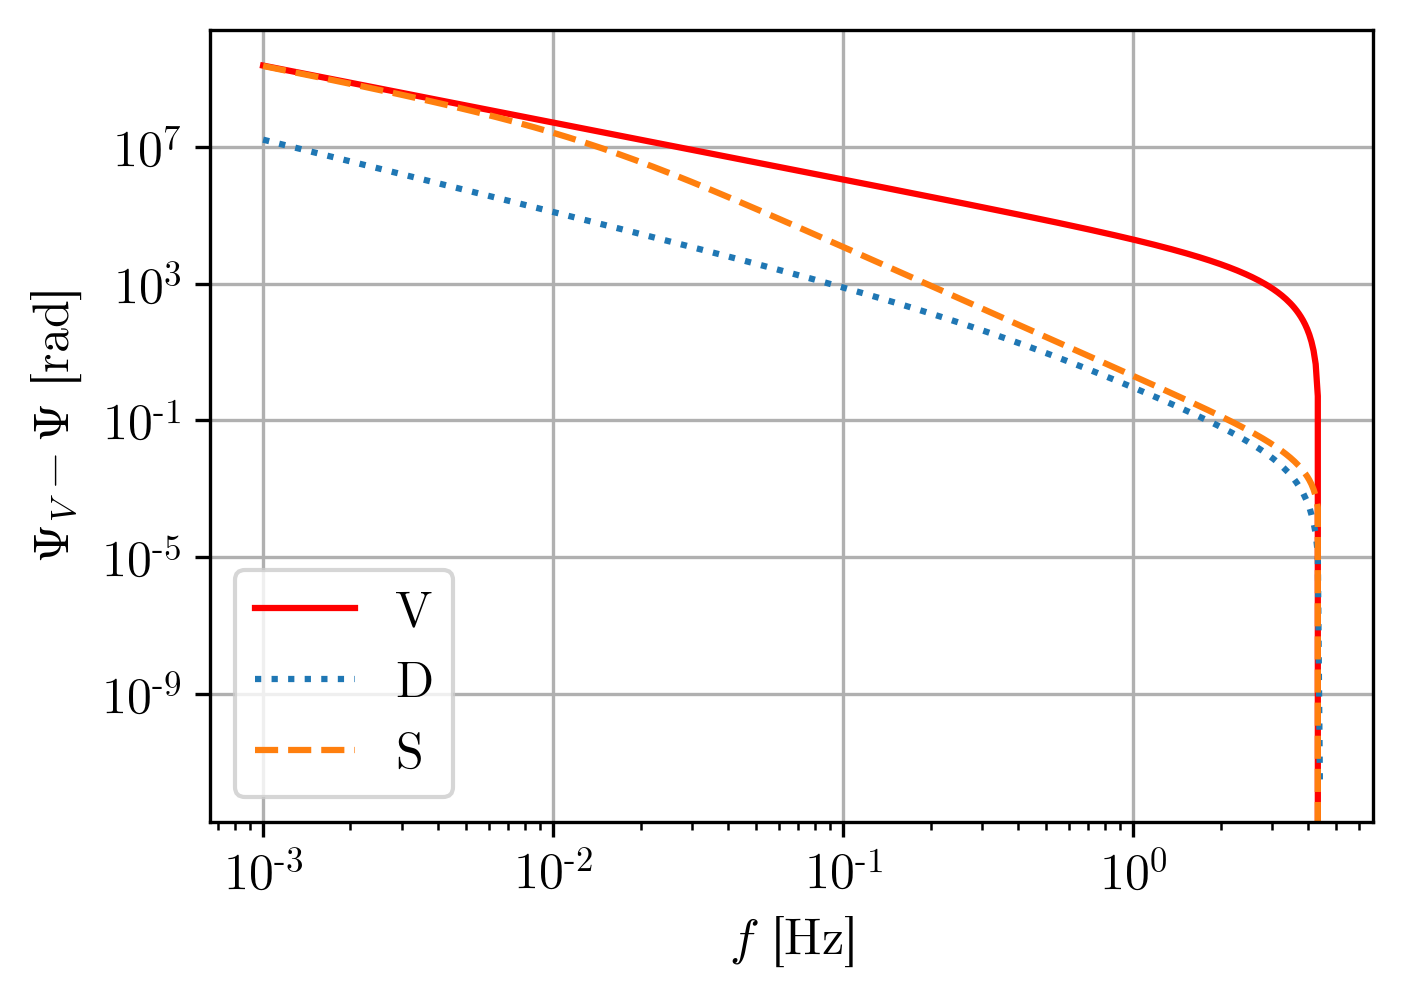

In [39]:
f = jnp.geomspace(1e-3, f_c, 500)
fig, ax = plt.subplots(1, 1)#, figsize=(14, 5))

ax.loglog(f, Psi(f, f_c, vb, "v"), "r", label="V")
ax.loglog(f, Psi(f, f_c, vb, "v") - Psi(f, f_c, dd, "d"), ":", label="D")
ax.loglog(f, Psi(f, f_c, vb, "v") - Psi(f, f_c, sd, "s"), "--", label="S")
ax.legend()
ax.grid()
ax.set_xlabel(r"$f$ [Hz]")
ax.set_ylabel(r"$\Psi_V - \Psi$ [rad]")

### Likelihood checks

In [5]:
from jax import jit

With scipy:
```
SNR(s) =  9.193779235810998
SNR(h) =  9.196551816697275
log L(s|s) =  42.262788318414735
log L(h|h) =  42.28828265859896
log L(h|s) =  42.08482816097782
```

With jax interpolator, `trapz` and 5000 points:
```
SNR(s) =  9.19376753760959
SNR(h) =  9.196541692746678
log L(s|s) =  42.26268076780195
log L(h|h) =  42.288189553213975
log L(h|s) =  42.08425870908815
```

With jax interpolator, `simps` and 5000 points:
```
SNR(s) =  9.193760960108834
SNR(h) =  9.196536000394095
log L(s|s) =  42.262620295810656
log L(h|h) =  42.28813720327233
log L(h|s) =  42.084231124778
```

With jax interpolator, `simps` and 3000 points:
```
SNR(s) =  9.193760960111337
SNR(h) =  9.196536000395968
log L(s|s) =  42.26262029583365
log L(h|h) =  42.288137203289544
log L(h|s) =  42.08419191768377
```
Seems good enough.

In [46]:
test_SNR_loglikelihood()

SNR(s) =  9.193760960111337
SNR(h) =  9.196536000395968
log L(s|s) =  42.26262029583365
log L(h|h) =  42.288137203289544
log L(h|s) =  42.08419191768377


In [47]:
calculate_SNR_jit = jit(calculate_SNR, static_argnums=(2, 5))
loglikelihood_jit = jit(loglikelihood, static_argnums=(2, 5, 8, 9))

In [48]:
dd_s = DynamicDress(
    jnp.array(2.3333333333333335),
    jnp.array(0.00018806659428775589),
    jnp.array(3.151009407916561e31),
    jnp.array(0.001),
    jnp.array(0.0),
    jnp.array(0.0),
    jnp.array(-56.3888135025341),
)

dd_h = DynamicDress(
    jnp.array(2.2622788817665738),
    jnp.array(4.921717647731646e-5),
    jnp.array(3.151580260164573e31),
    jnp.array(0.0005415094825728555),
    jnp.array(dd_s.Phi_c),
    jnp.array(-227.74995698),
    jnp.array(dd_s.dL_iota),
)
f_c = get_f_isco(get_m_1(dd_s.M_chirp, dd_s.q))
f_l = jnp.array(0.022621092492458004)  # Hz
f_c_h = get_f_isco(get_m_1(dd_h.M_chirp, dd_h.q))

# Compile the functions
loglikelihood_jit(dd_s, f_c, "d", dd_s, f_c, "d", f_l, f_c, 5000, 5000)
calculate_SNR_jit(dd_s, f_c, "d", f_l, f_c, 3000)

DeviceArray(9.19377924, dtype=float64)

In [49]:
%timeit calculate_SNR_jit(dd_s, f_c, "d", f_l, f_c, 500)

111 µs ± 2.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [50]:
%timeit calculate_SNR_jit(dd_h, f_c_h, "d", f_l, f_c, 3000)

265 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [52]:
%%timeit
loglikelihood_jit(dd_s, f_c, "d", dd_s, f_c, "d", f_l, f_c, 3000, 3000)
loglikelihood_jit(dd_h, f_c_h, "d", dd_h, f_c_h, "d", f_l, f_c_h, 3000, 3000)
loglikelihood_jit(dd_h, f_c_h, "d", dd_s, f_c, "d", f_l, f_c, 3000, 3000)

7.24 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### jaxns

In [4]:
from jaxns.nested_sampling import NestedSampler, save_results, load_results
from jaxns.prior_transforms import UniformPrior, PriorChain
from jaxns.plotting import plot_diagnostics, plot_cornerplot
from jaxns.utils import summary, resample

#### Vacuum system

In [185]:
m_1 = 1e3 * MSUN
m_2 = 1 * MSUN
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1)
vb_s = make_vacuum_binary(m_1, m_2)

def logL(M_chirp, tT_c, **kwargs):
    vb_h = VacuumBinary(M_chirp, vb_s.Phi_c, tT_c, dL_iota=vb_s.dL_iota)
    return loglikelihood(vb_h, f_c, "v", vb_s, f_c, "v", f_l, f_c)

prior_M_chirp = UniformPrior(
    'M_chirp', vb_s.M_chirp * (1 - 2e-7), vb_s.M_chirp * (1 + 2e-7)
)
prior_tT_c = UniformPrior('tT_c', -10., 10.)
prior_chain = PriorChain().push(prior_M_chirp).push(prior_tT_c)

ns = NestedSampler(
    loglikelihood=logL,
    prior_chain=prior_chain,
    sampler_name='slice',
#     num_parallel_samplers=1,
#     sampler_kwargs=dict(depth=5, num_slices=prior_chain.U_ndims*5),
    num_live_points=300,
    max_samples=1e4,
    collect_samples=True,
    collect_diagnostics=True
)
results = jax.jit(ns)(random.PRNGKey(17345), termination_frac=0.001)

summary(results)

ESS=1355.5791707866344
--------
M_chirp: mean +- std.dev. | 10%ile / 50%ile / 90%ile | max(L) est.
M_chirp: 3.1510094e+31 +- 1e+24 | 3.1510093e+31 / 3.1510093e+31 / 3.1510095e+31 | 3.1510094e+31
--------
tT_c: mean +- std.dev. | 10%ile / 50%ile / 90%ile | max(L) est.
tT_c: -0.0 +- 3.0 | -3.0 / -0.0 / 3.0 | -0.0
--------


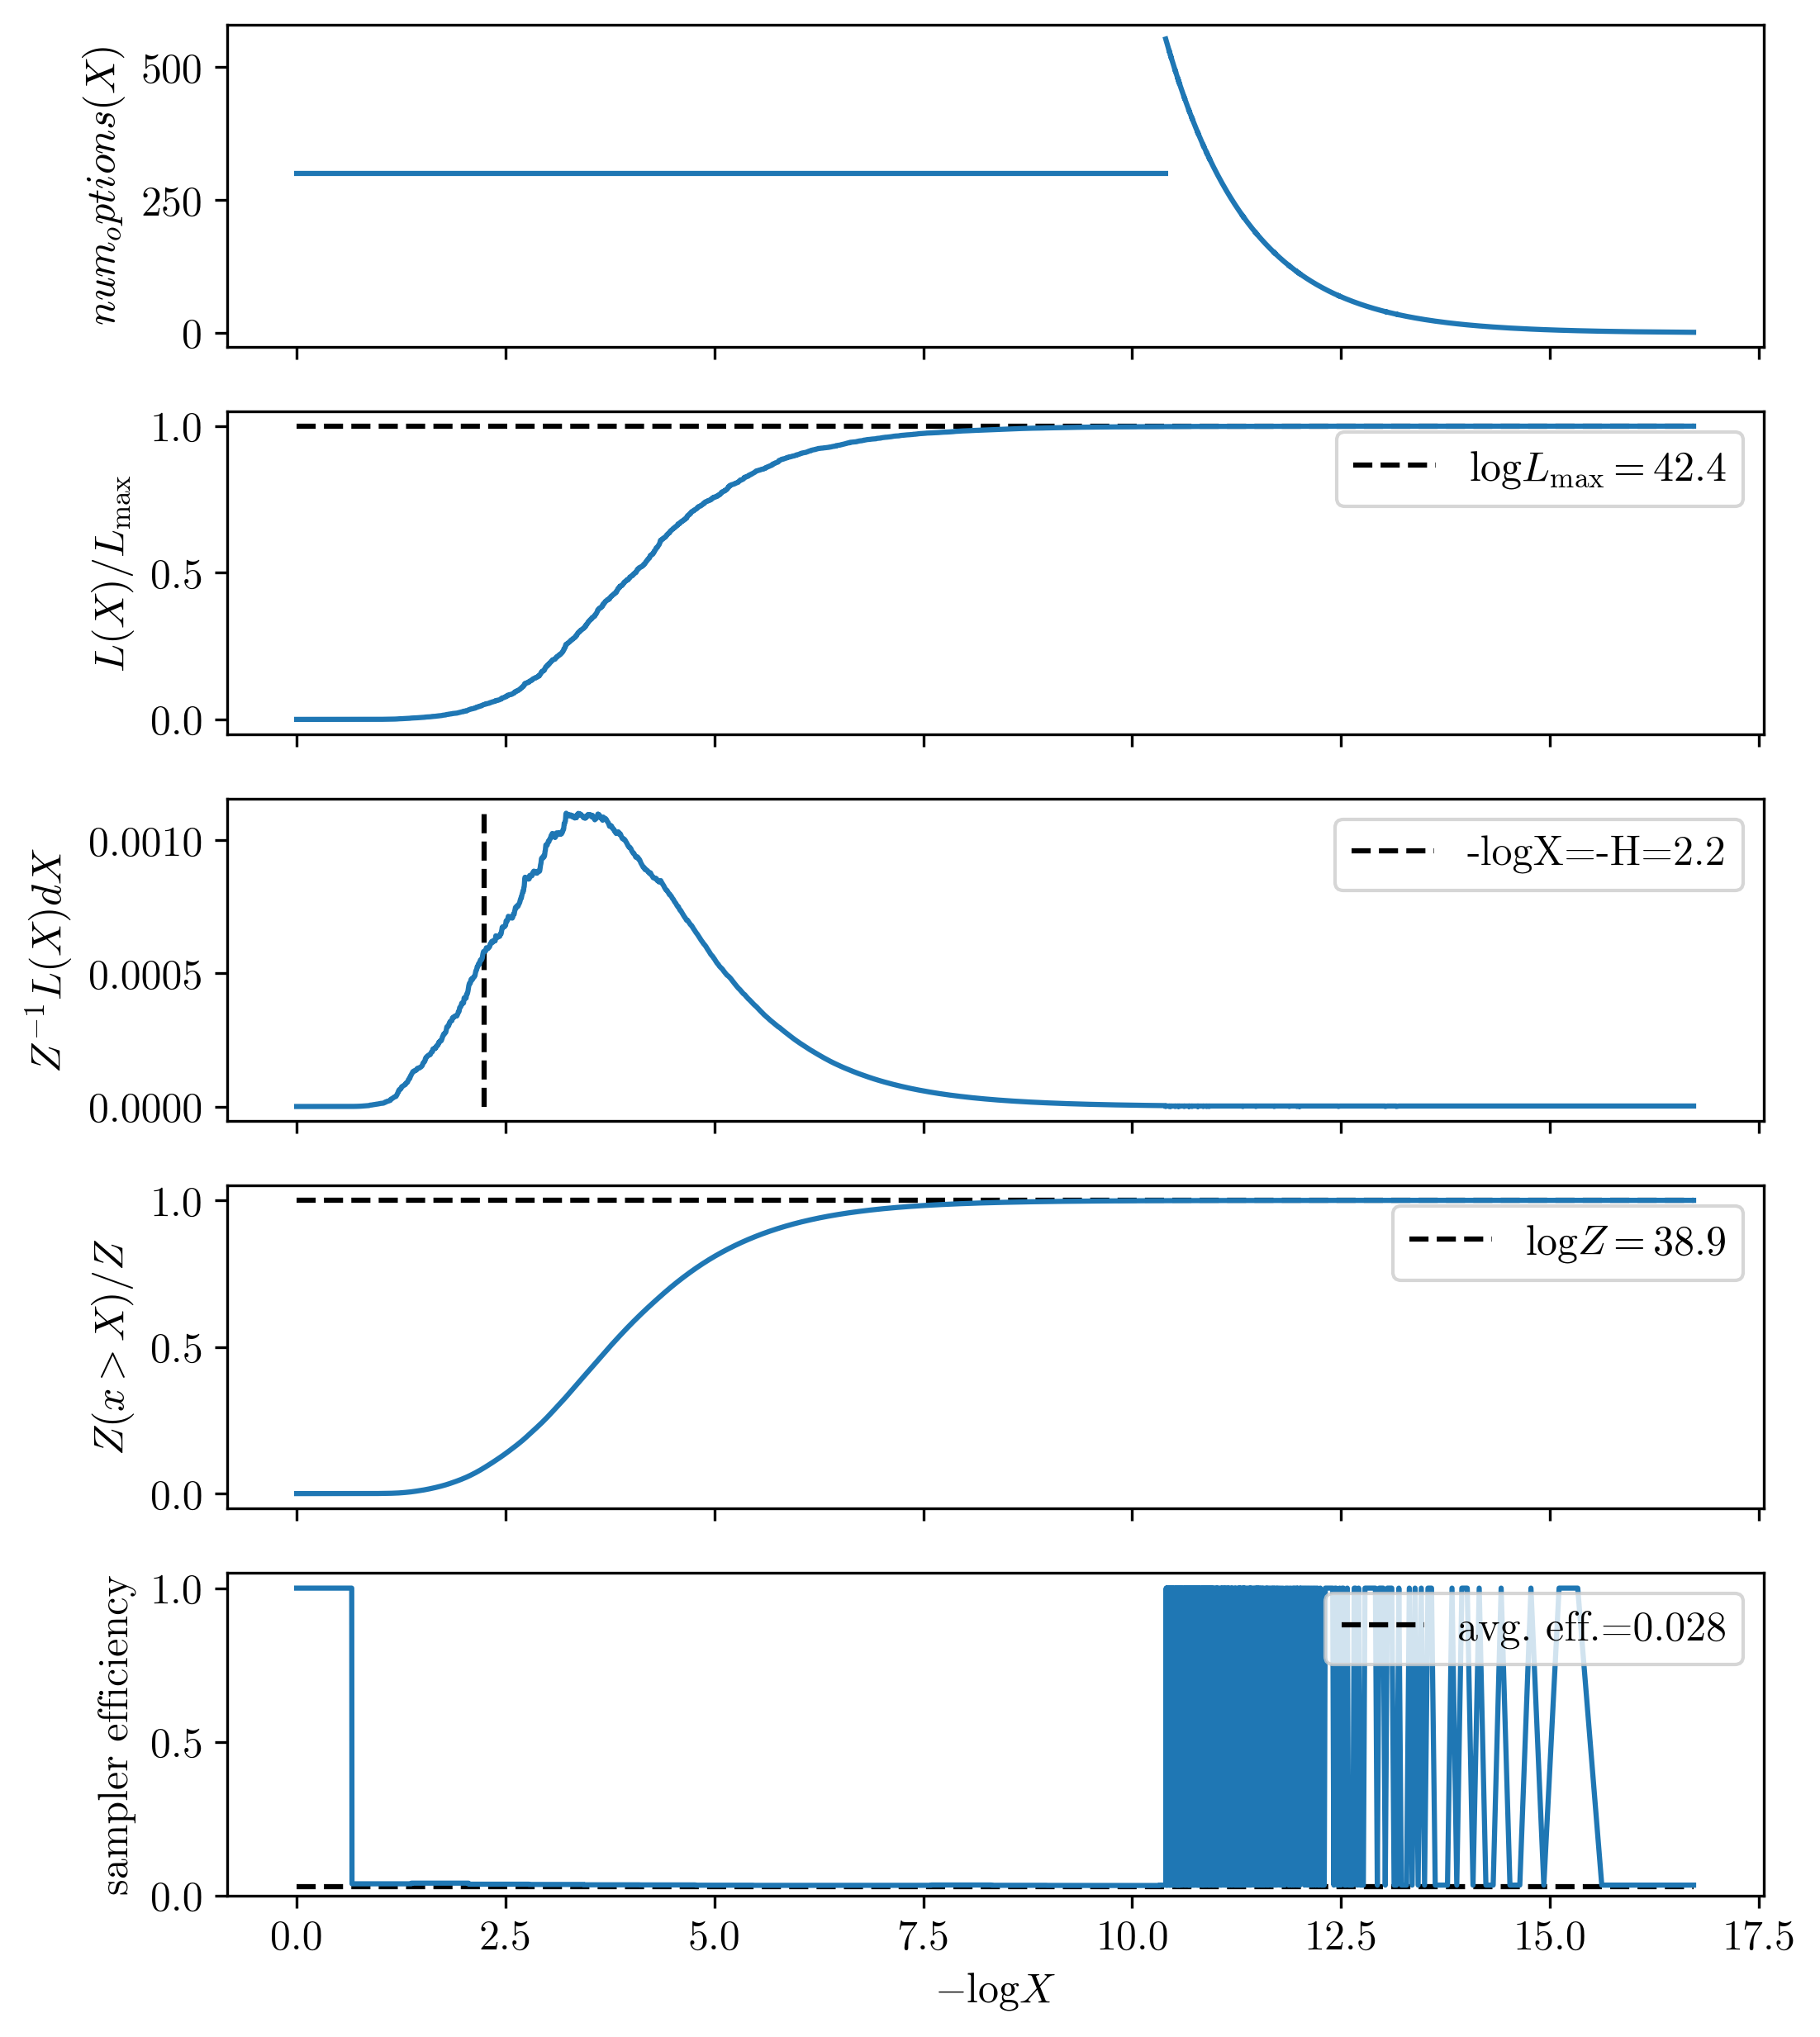

In [186]:
plot_diagnostics(results)

Text(0.5, 0, '$\\tilde{t}_c$ [s]')

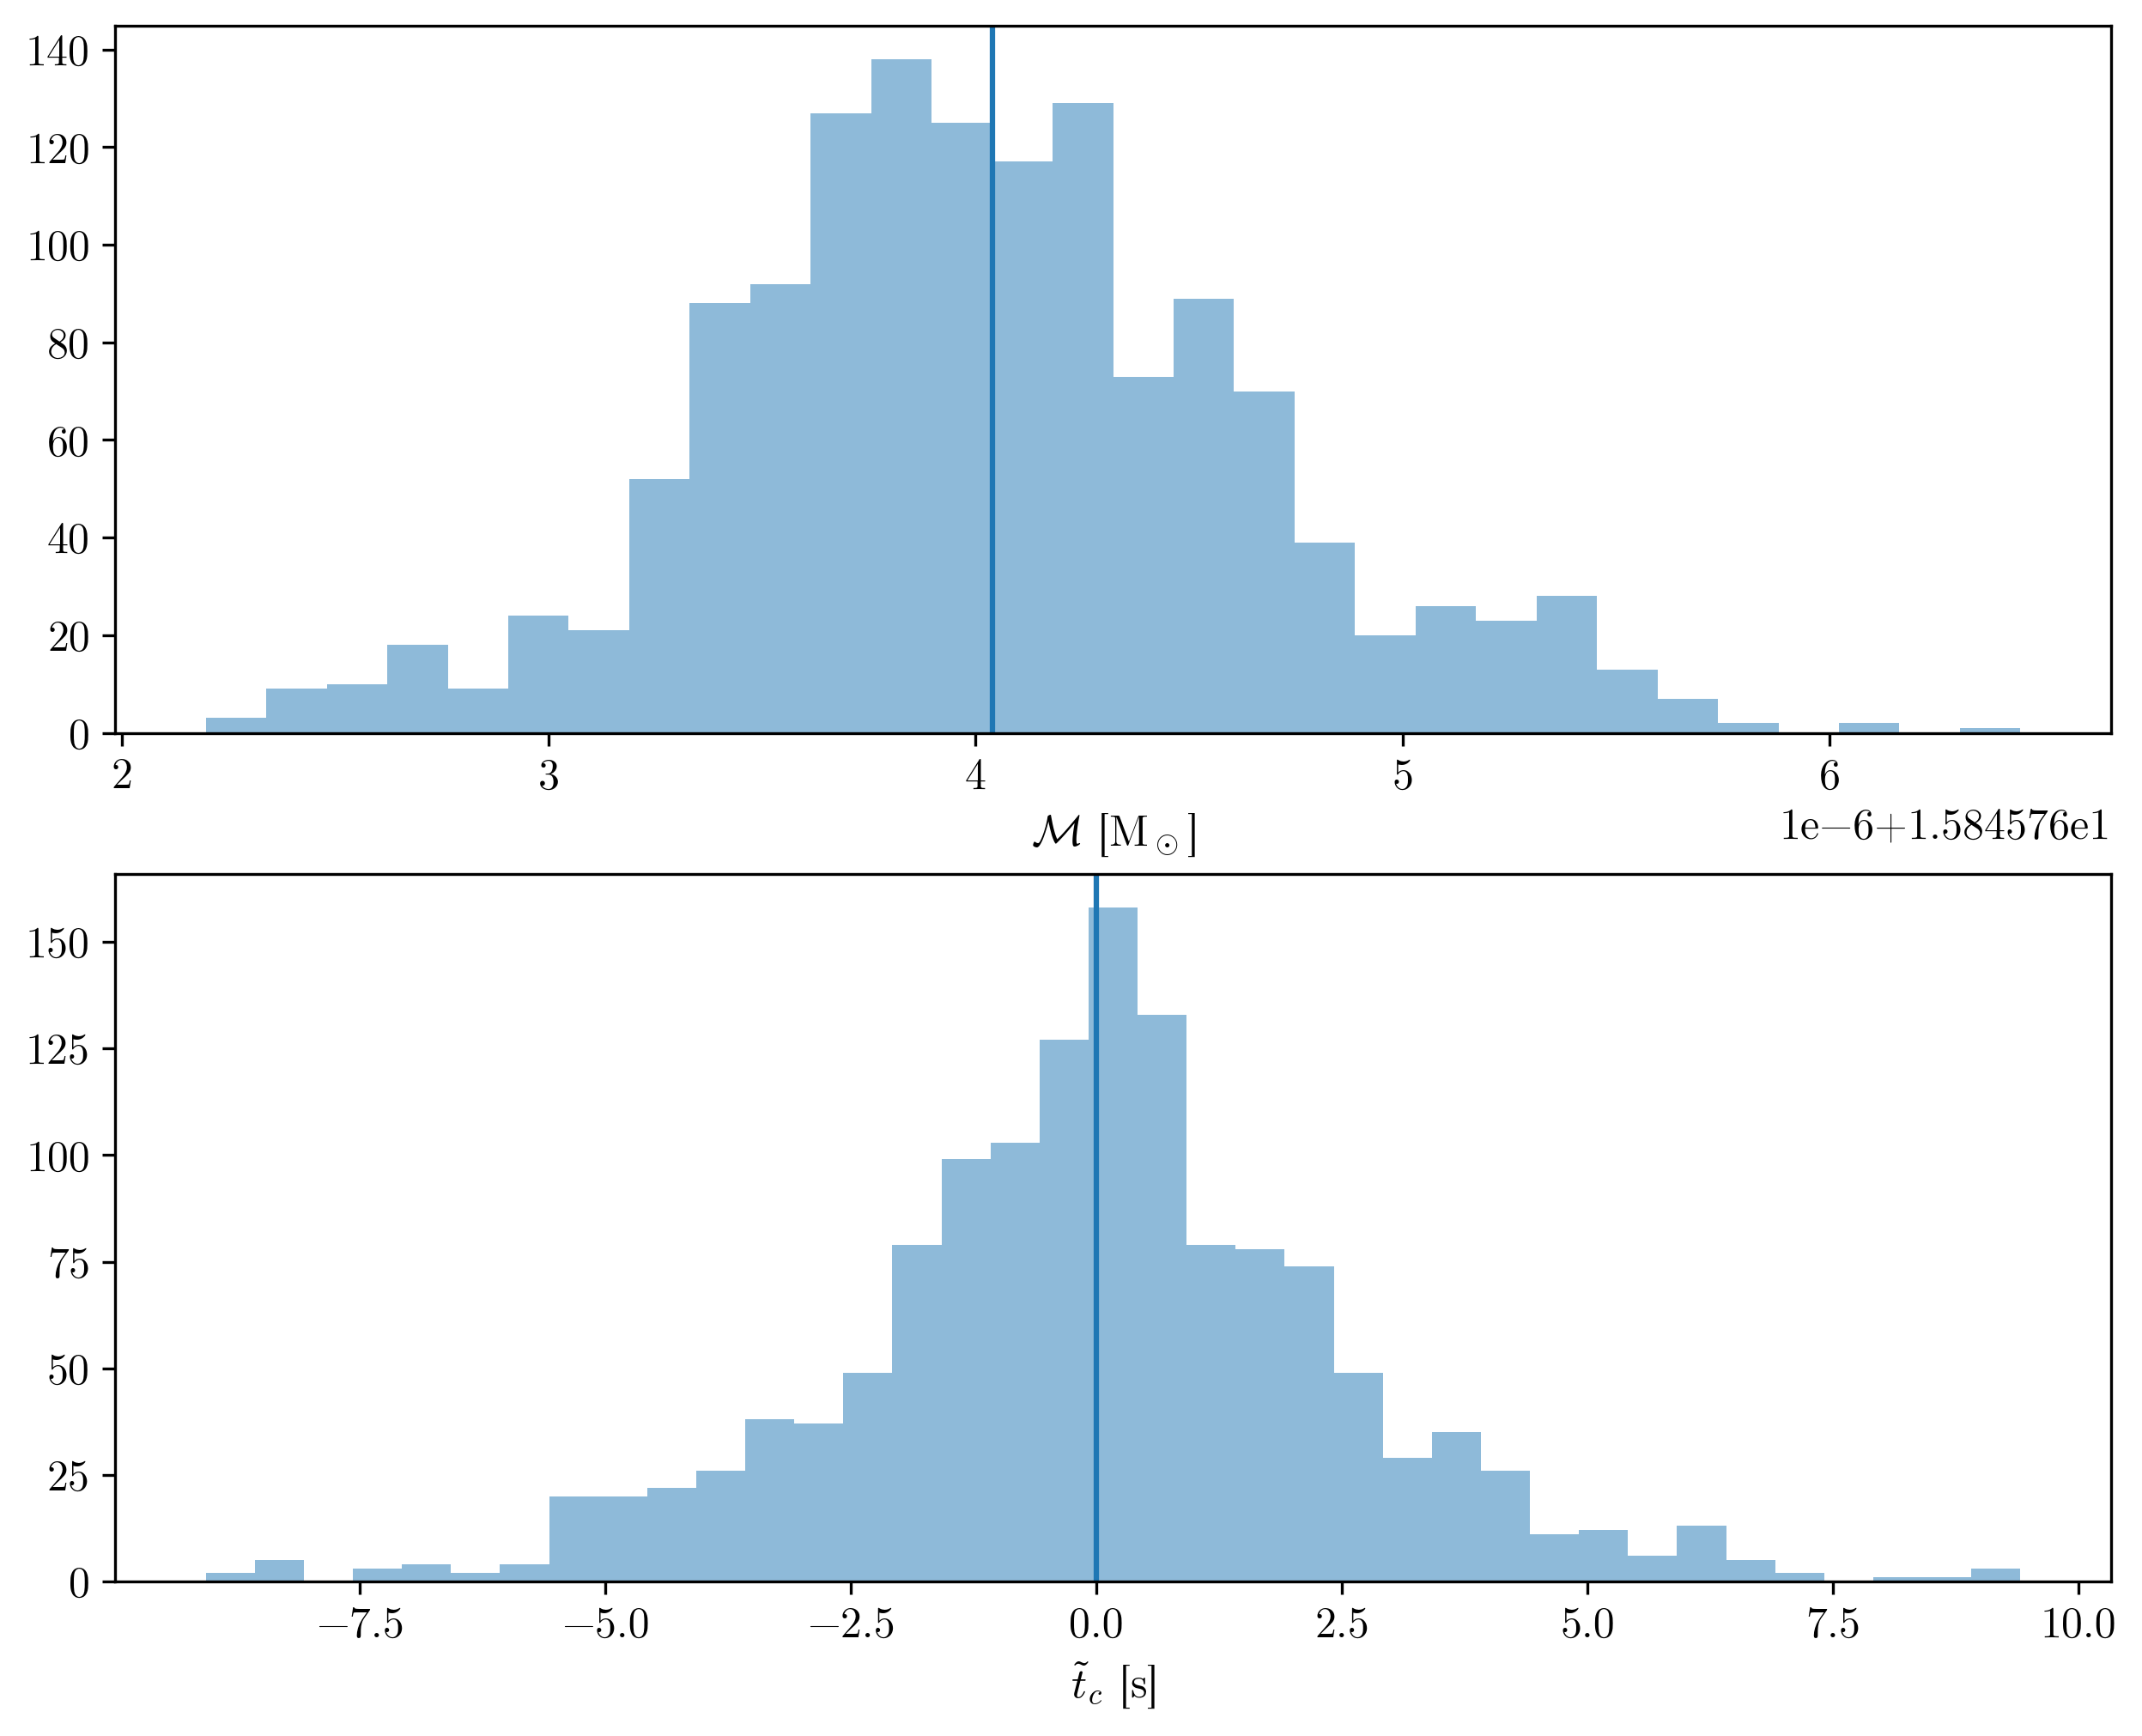

In [187]:
# plot_cornerplot(results)

samples = resample(random.PRNGKey(45),results.samples, results.log_p, S=int(results.ESS))

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

ax = axes[0]
ax.hist(samples['M_chirp'] / MSUN, bins='auto', alpha=0.5)
ax.axvline(vb_s.M_chirp / MSUN)
ax.set_xlabel(r"$\mathcal{M}$ [M$_\odot$]")

ax = axes[1]
ax.hist(samples['tT_c'], bins='auto', alpha=0.5)
ax.axvline(vb_s.tT_c)
ax.set_xlabel(r"$\tilde{t}_c$ [s]")

#### Dynamic system

In [5]:
m_1 = jnp.array(1e3 * MSUN)
m_2 = jnp.array(1 * MSUN)
rho_s = jnp.array(226 * MSUN / PC**3)
gamma_s = jnp.array(7 / 3)
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1)
dd_s = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)


def logL(M_chirp_MSUN, tT_c, **kwargs):
    dd_h = DynamicDress(
        dd_s.gamma_s,
        dd_s.c_f,
        M_chirp,
        dd_s.q,
        dd_s.Phi_c,
        tT_c,
        dL_iota=dd_s.dL_iota
    )
    f_c_h = get_f_isco(get_m_1(dd_h.M_chirp, dd_h.q))
    return loglikelihood(dd_h, f_c_h, "d", dd_s, f_c, "d", f_l, f_c)


prior_M_chirp = UniformPrior(
    'M_chirp', dd_s.M_chirp * (1 - 2e-7), dd_s.M_chirp * (1 + 2e-7)
)
prior_tT_c = UniformPrior('tT_c', -10., 10.)
prior_chain = PriorChain().push(prior_M_chirp).push(prior_tT_c)

In [ ]:
ns = NestedSampler(
    loglikelihood=logL,
    prior_chain=prior_chain,
    sampler_name='slice',
#     num_parallel_samplers=1,
#     sampler_kwargs=dict(depth=5, num_slices=prior_chain.U_ndims*5),
    num_live_points=300,
    max_samples=1e4,
    collect_samples=True,
    collect_diagnostics=True
)

# @jax.jit
# def run_jaxns(key):
#     return ns(key, termination_frac=0.001)

results = jax.jit(ns)(random.PRNGKey(17345), termination_frac=0.001)

summary(results)

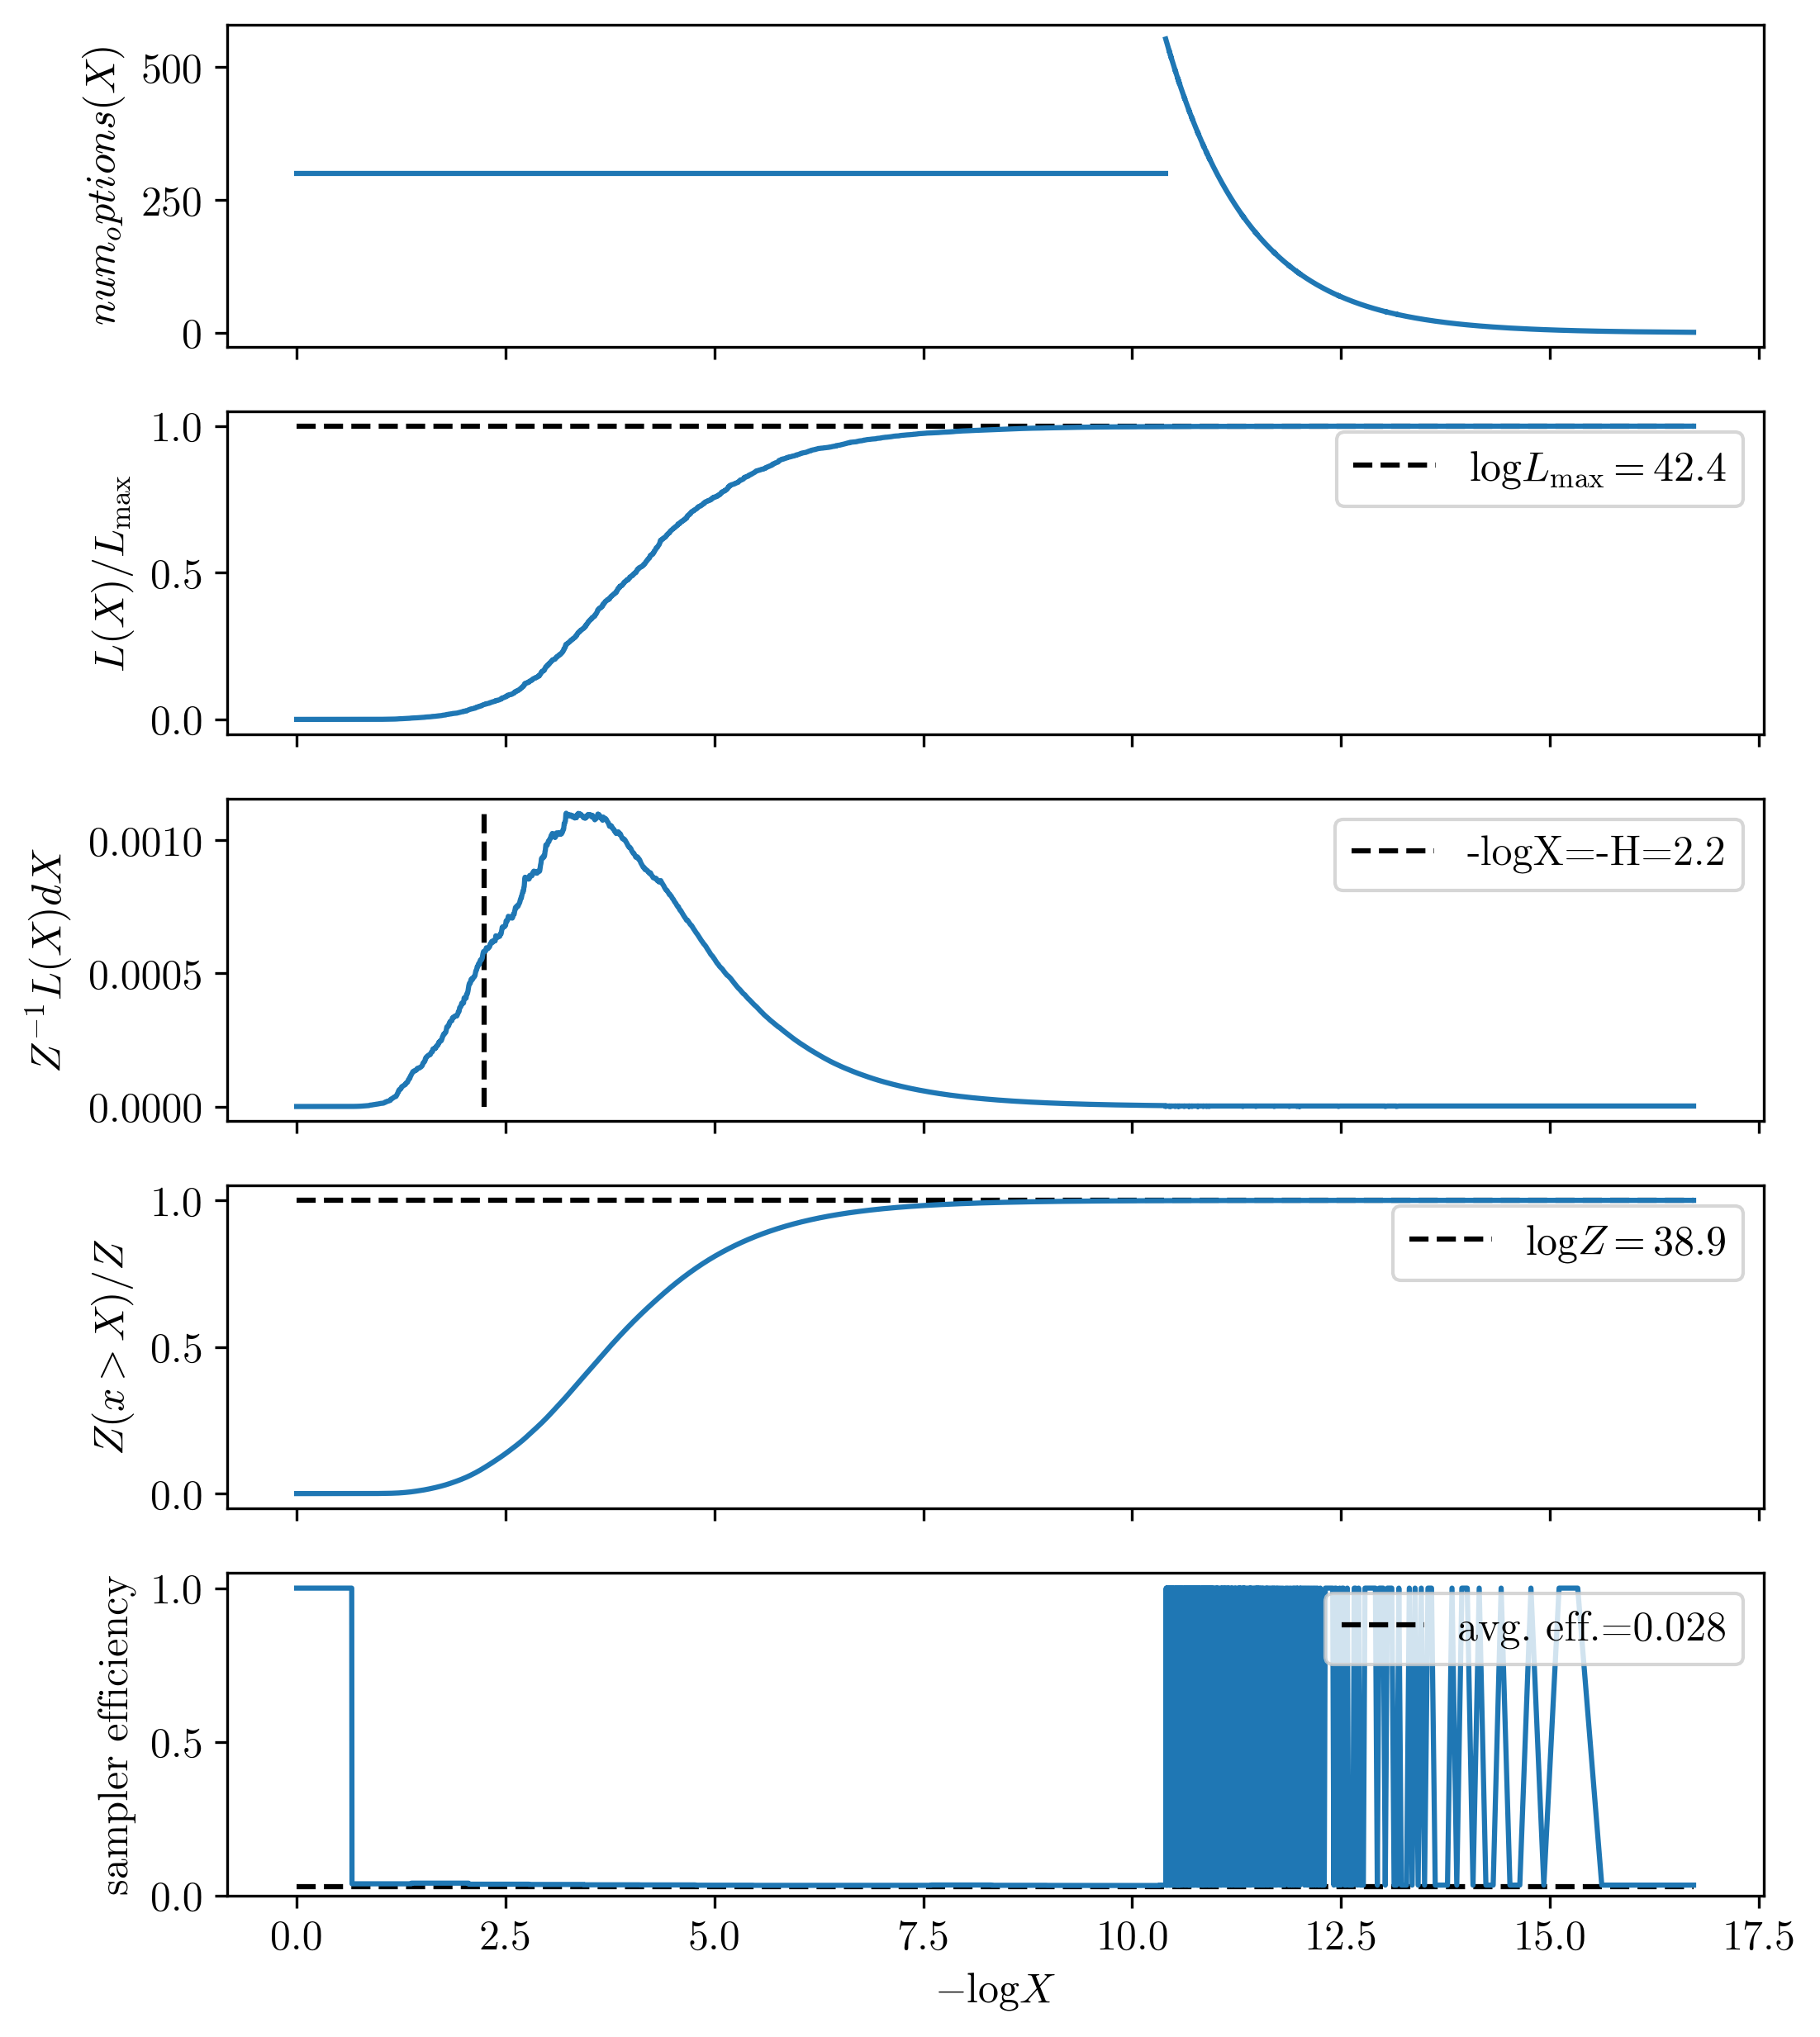

In [186]:
plot_diagnostics(results)

Text(0.5, 0, '$\\tilde{t}_c$ [s]')

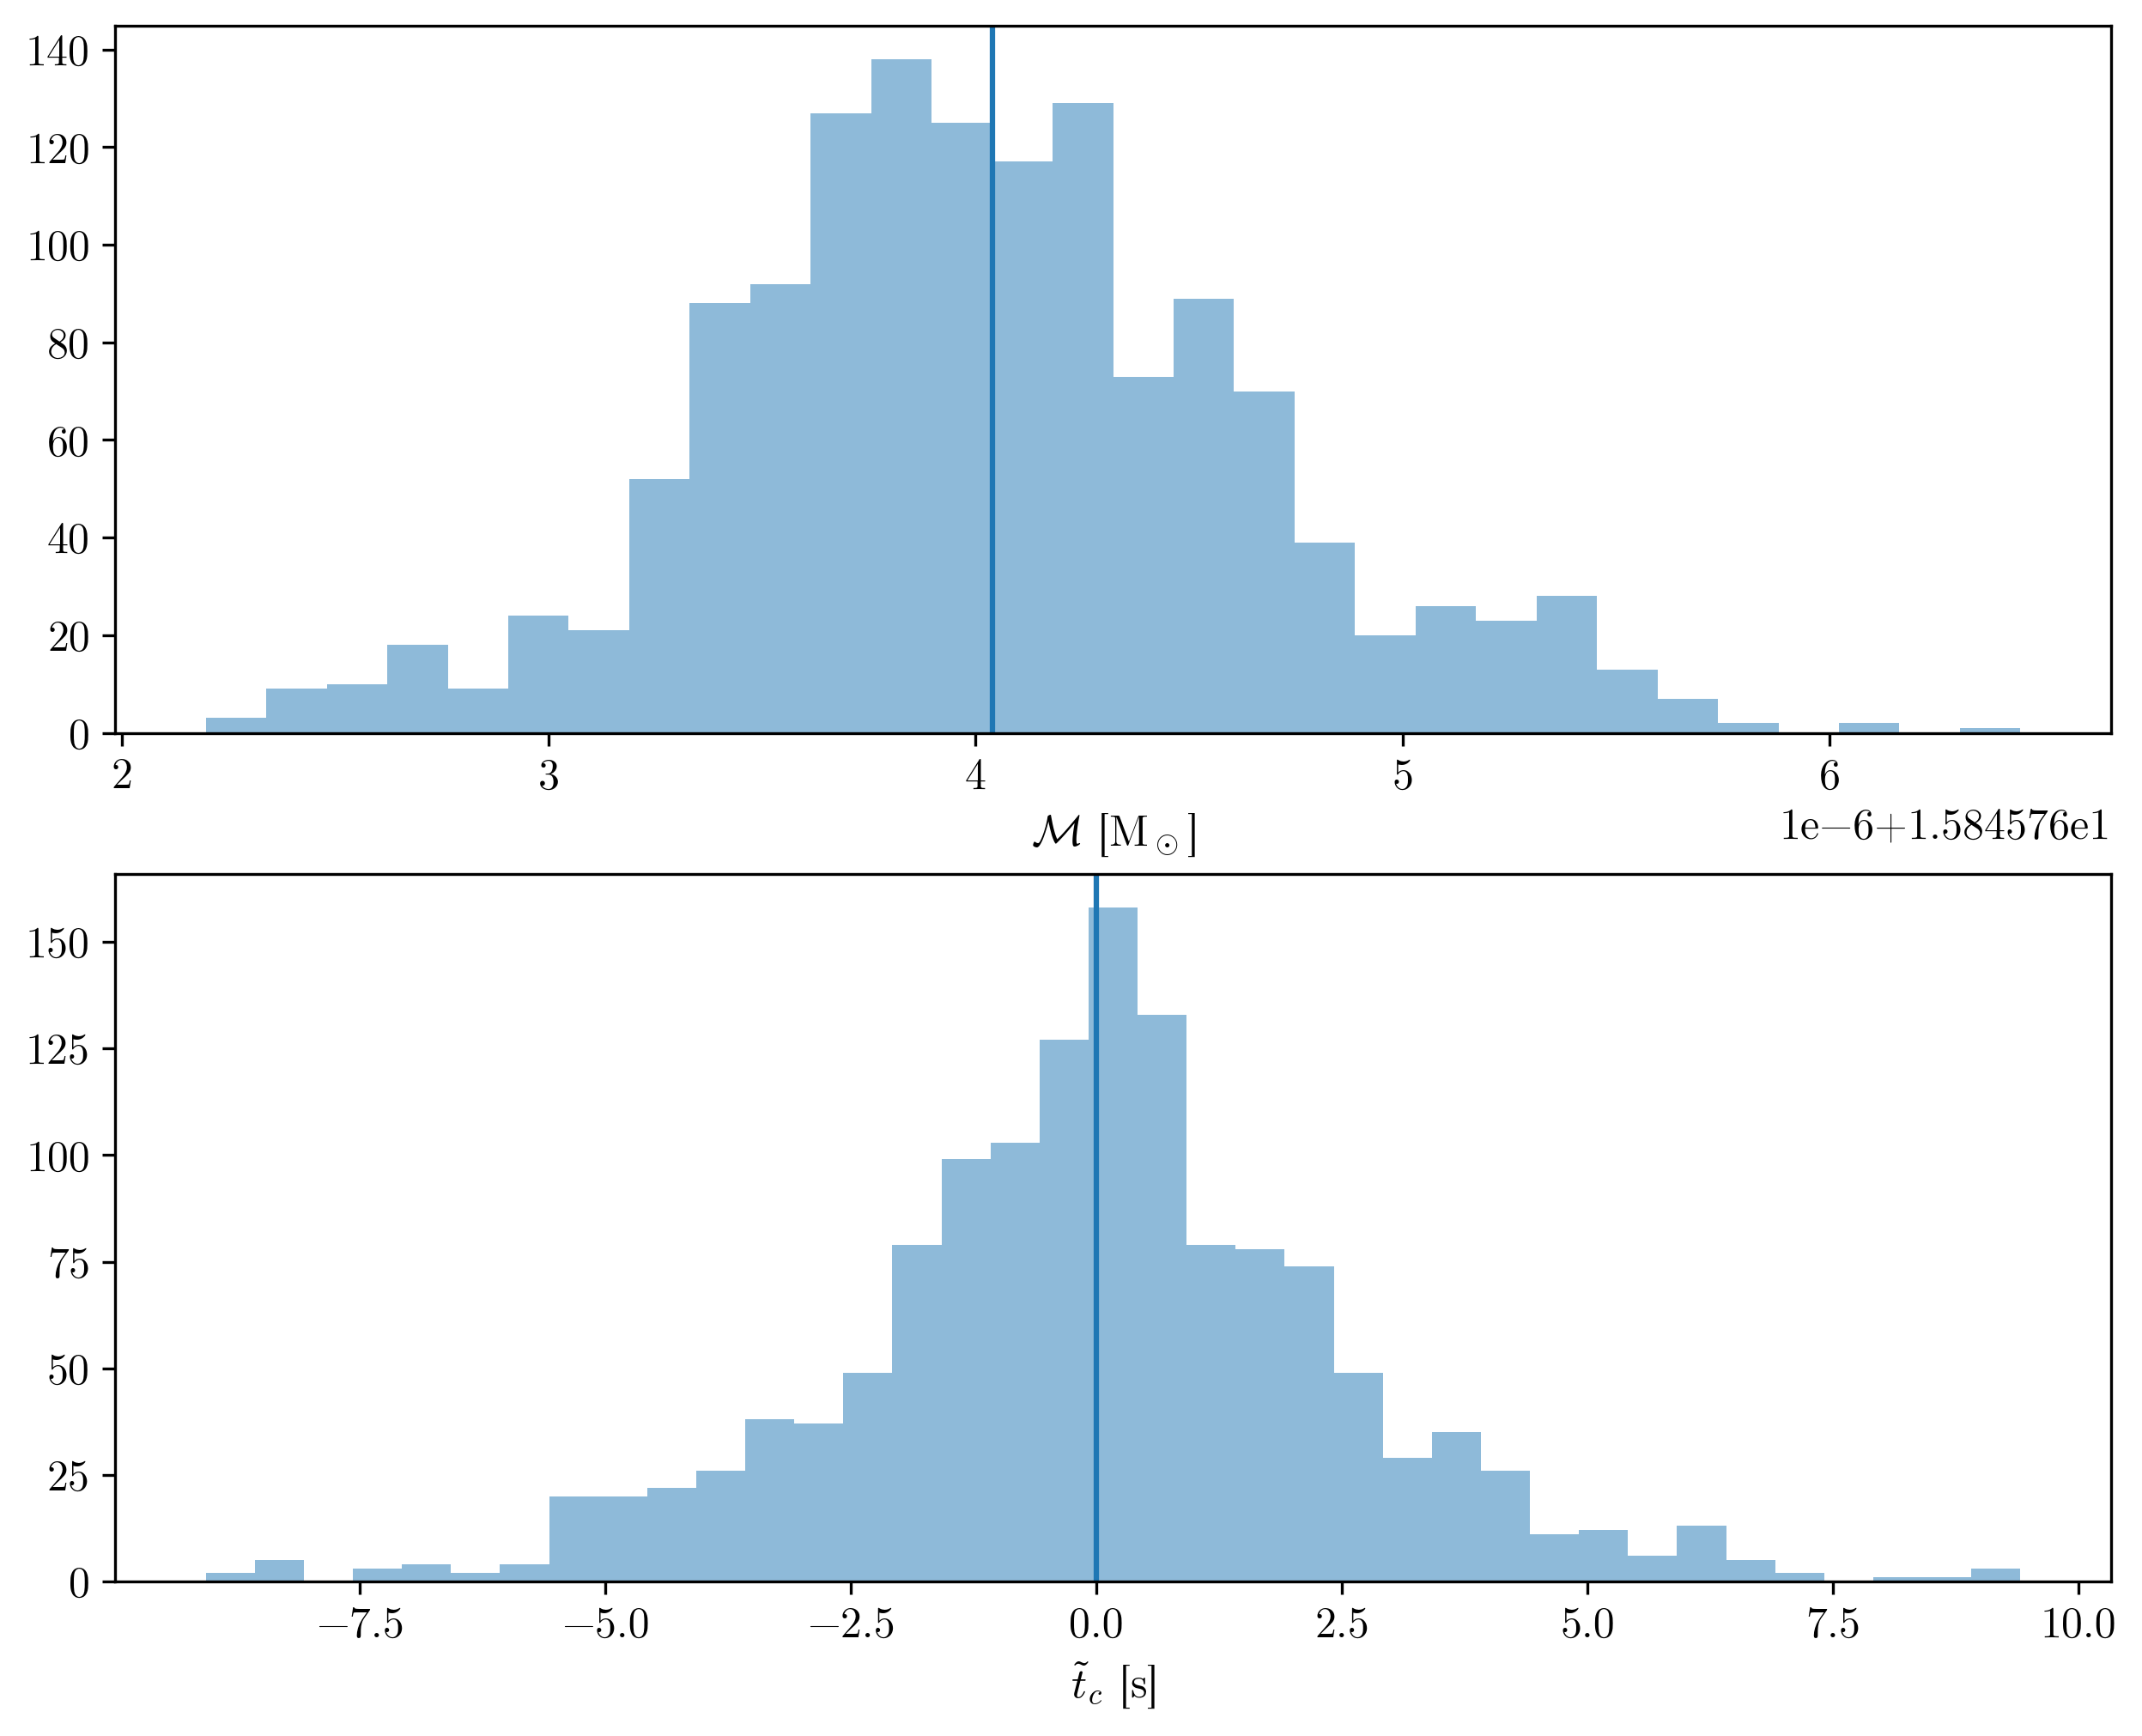

In [187]:
# plot_cornerplot(results)

samples = resample(random.PRNGKey(45),results.samples, results.log_p, S=int(results.ESS))

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

ax = axes[0]
ax.hist(samples['M_chirp'] / MSUN, bins='auto', alpha=0.5)
ax.axvline(vb_s.M_chirp / MSUN)
ax.set_xlabel(r"$\mathcal{M}$ [M$_\odot$]")

ax = axes[1]
ax.hist(samples['tT_c'], bins='auto', alpha=0.5)
ax.axvline(vb_s.tT_c)
ax.set_xlabel(r"$\tilde{t}_c$ [s]")

### Dynesty

#### Vacuum system

In [210]:
import dynesty
from dynesty import plotting as dyplot

In [243]:
m_1 = 1e3 * MSUN
m_2 = 1 * MSUN
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1)
vb_s = make_vacuum_binary(m_1, m_2)

def ptform(u):
    return jnp.array([
        vb_s.M_chirp / MSUN * (1 + u[0] * 4e-7 - 2e-7),
        u[1] * 20 - 10
    ])

@jax.jit
def logL_dynesty(x):
    M_chirp_MSUN, tT_c = x
    vb_h = VacuumBinary(M_chirp_MSUN * MSUN, vb_s.Phi_c, tT_c, dL_iota=vb_s.dL_iota)
    return _loglikelihood(vb_h, f_c, "v", vb_s, f_c, "v", f_l, f_c)

sampler = dynesty.NestedSampler(logL_dynesty, ptform, 2, nlive=300)
sampler.run_nested()
results = sampler.results

1396it [00:12, 115.68it/s, +300 | bound: 2 | nc: 1 | ncall: 11247 | eff(%): 15.080 | loglstar:   -inf < 42.353 <    inf | logz: 38.989 +/-  0.127 | dlogz:  0.001 >  0.309]


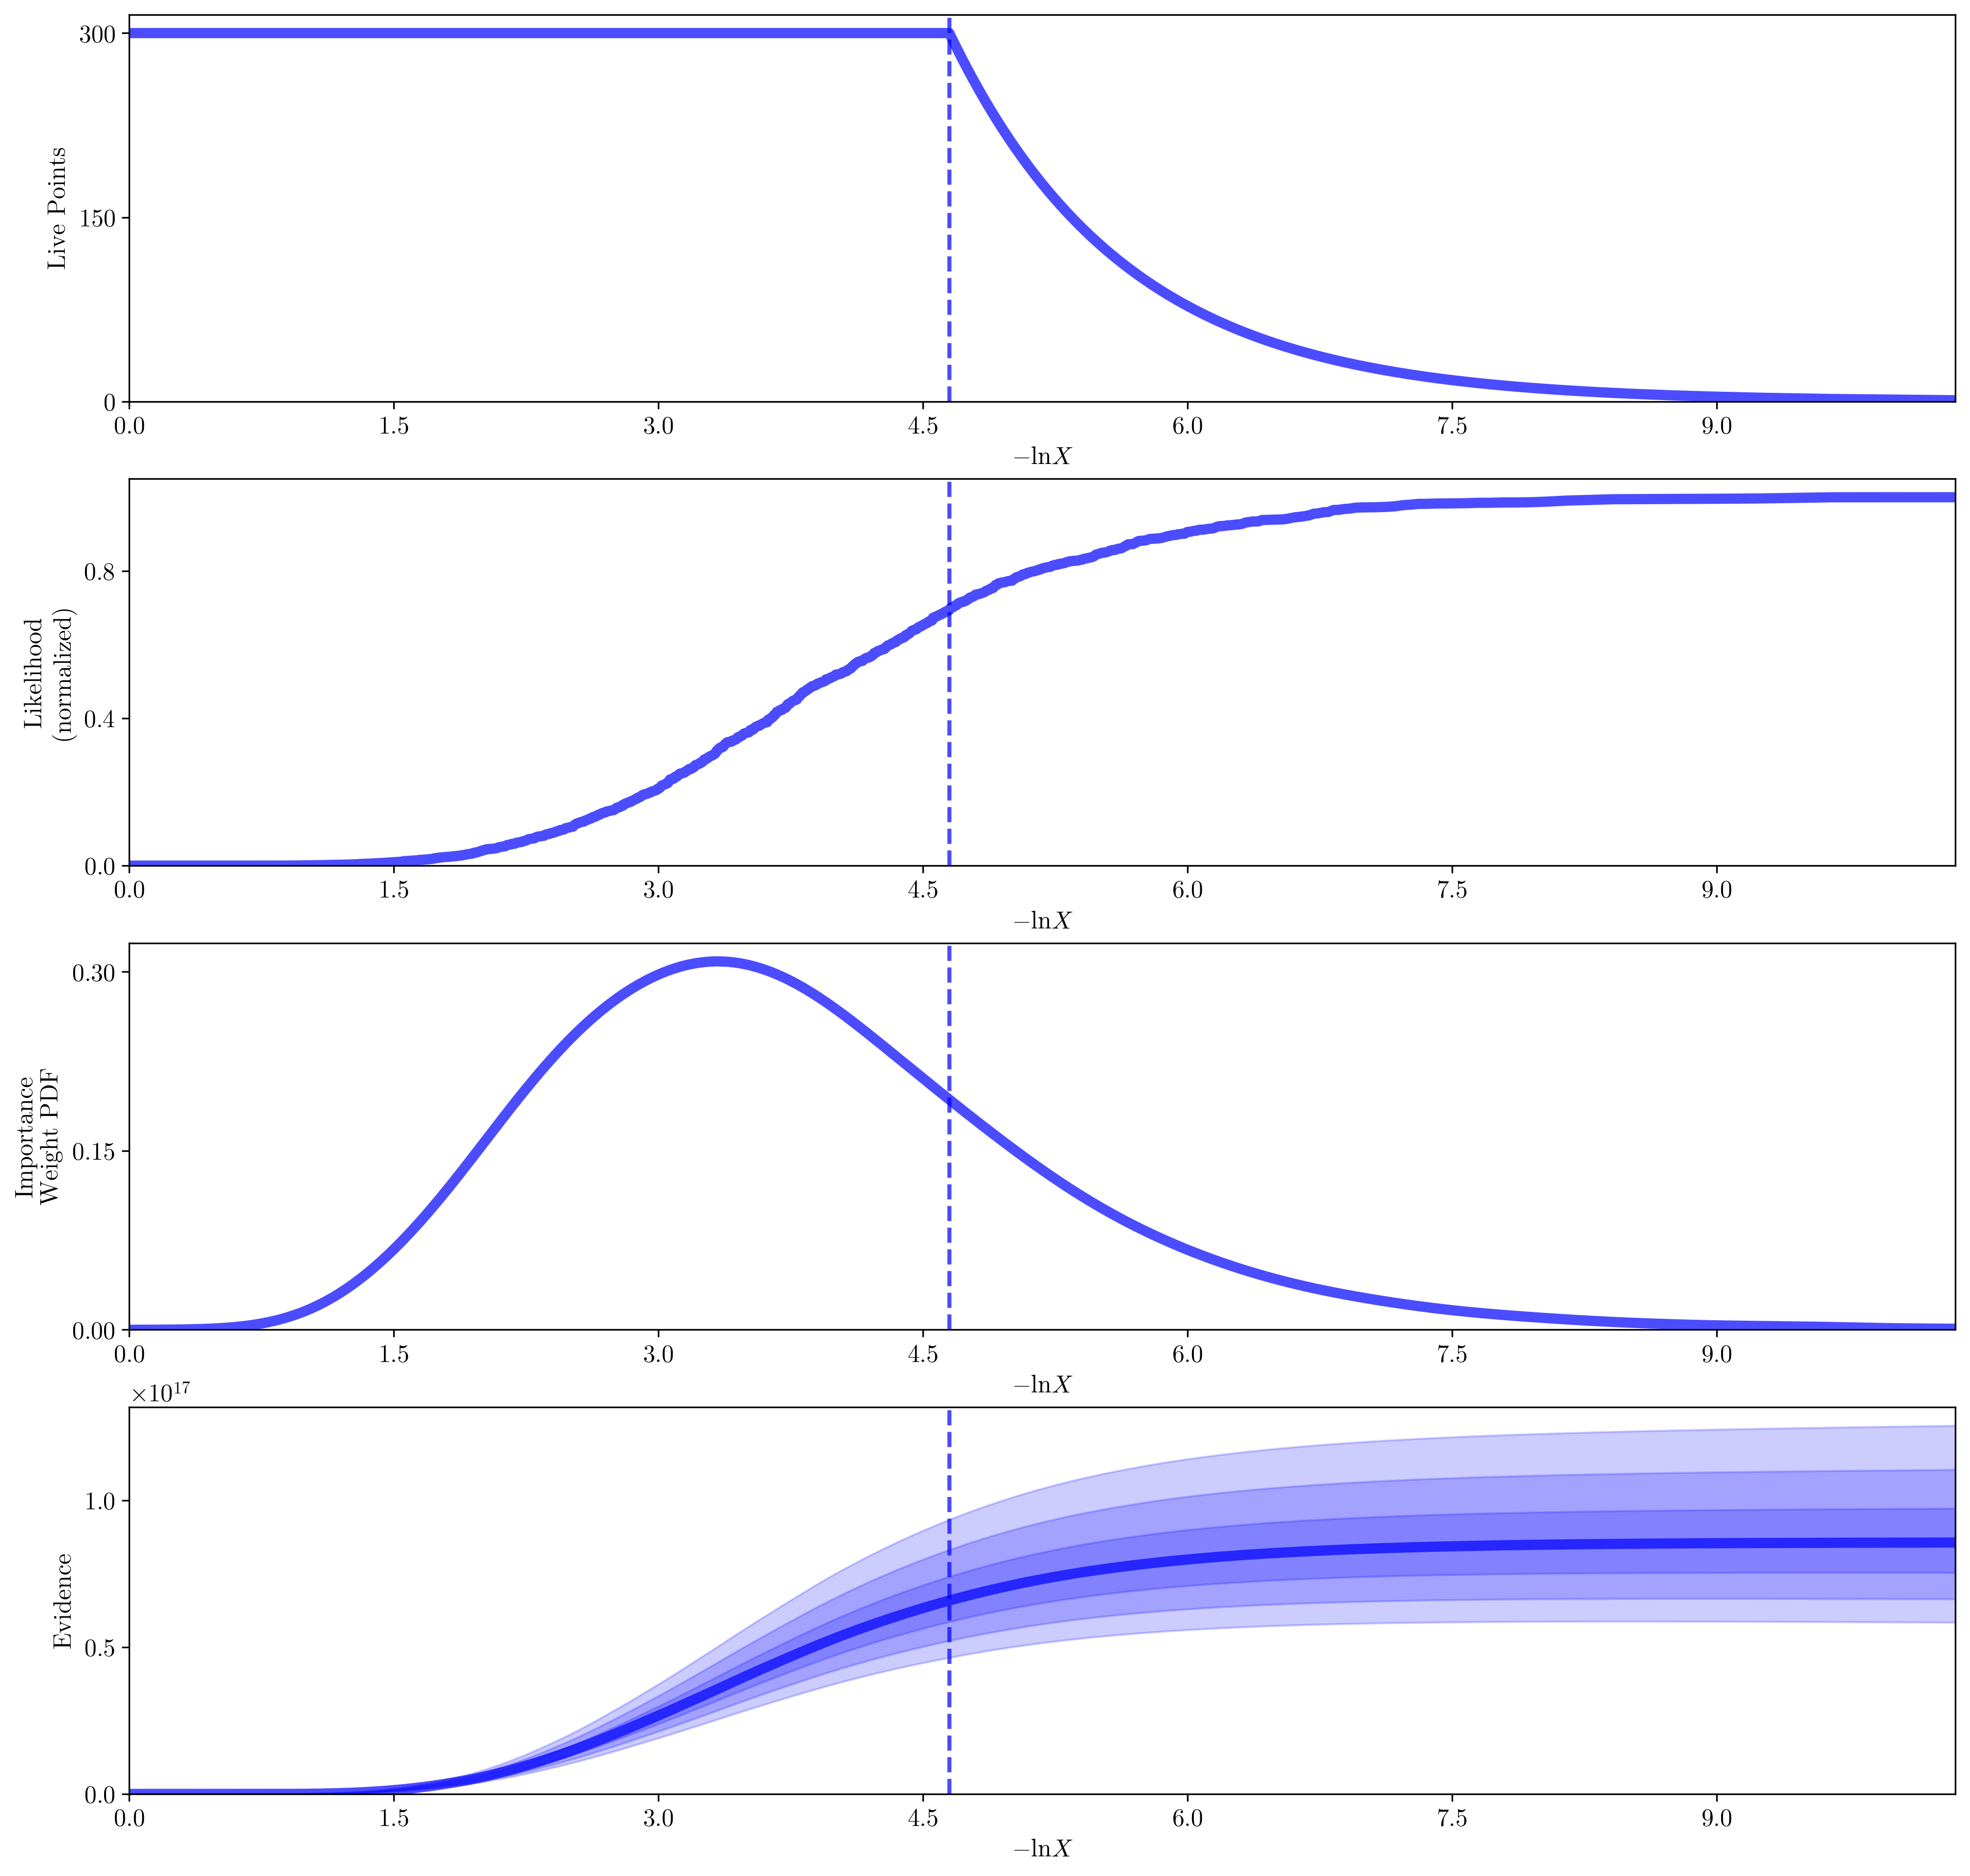

In [244]:
rfig, raxes = dyplot.runplot(results)

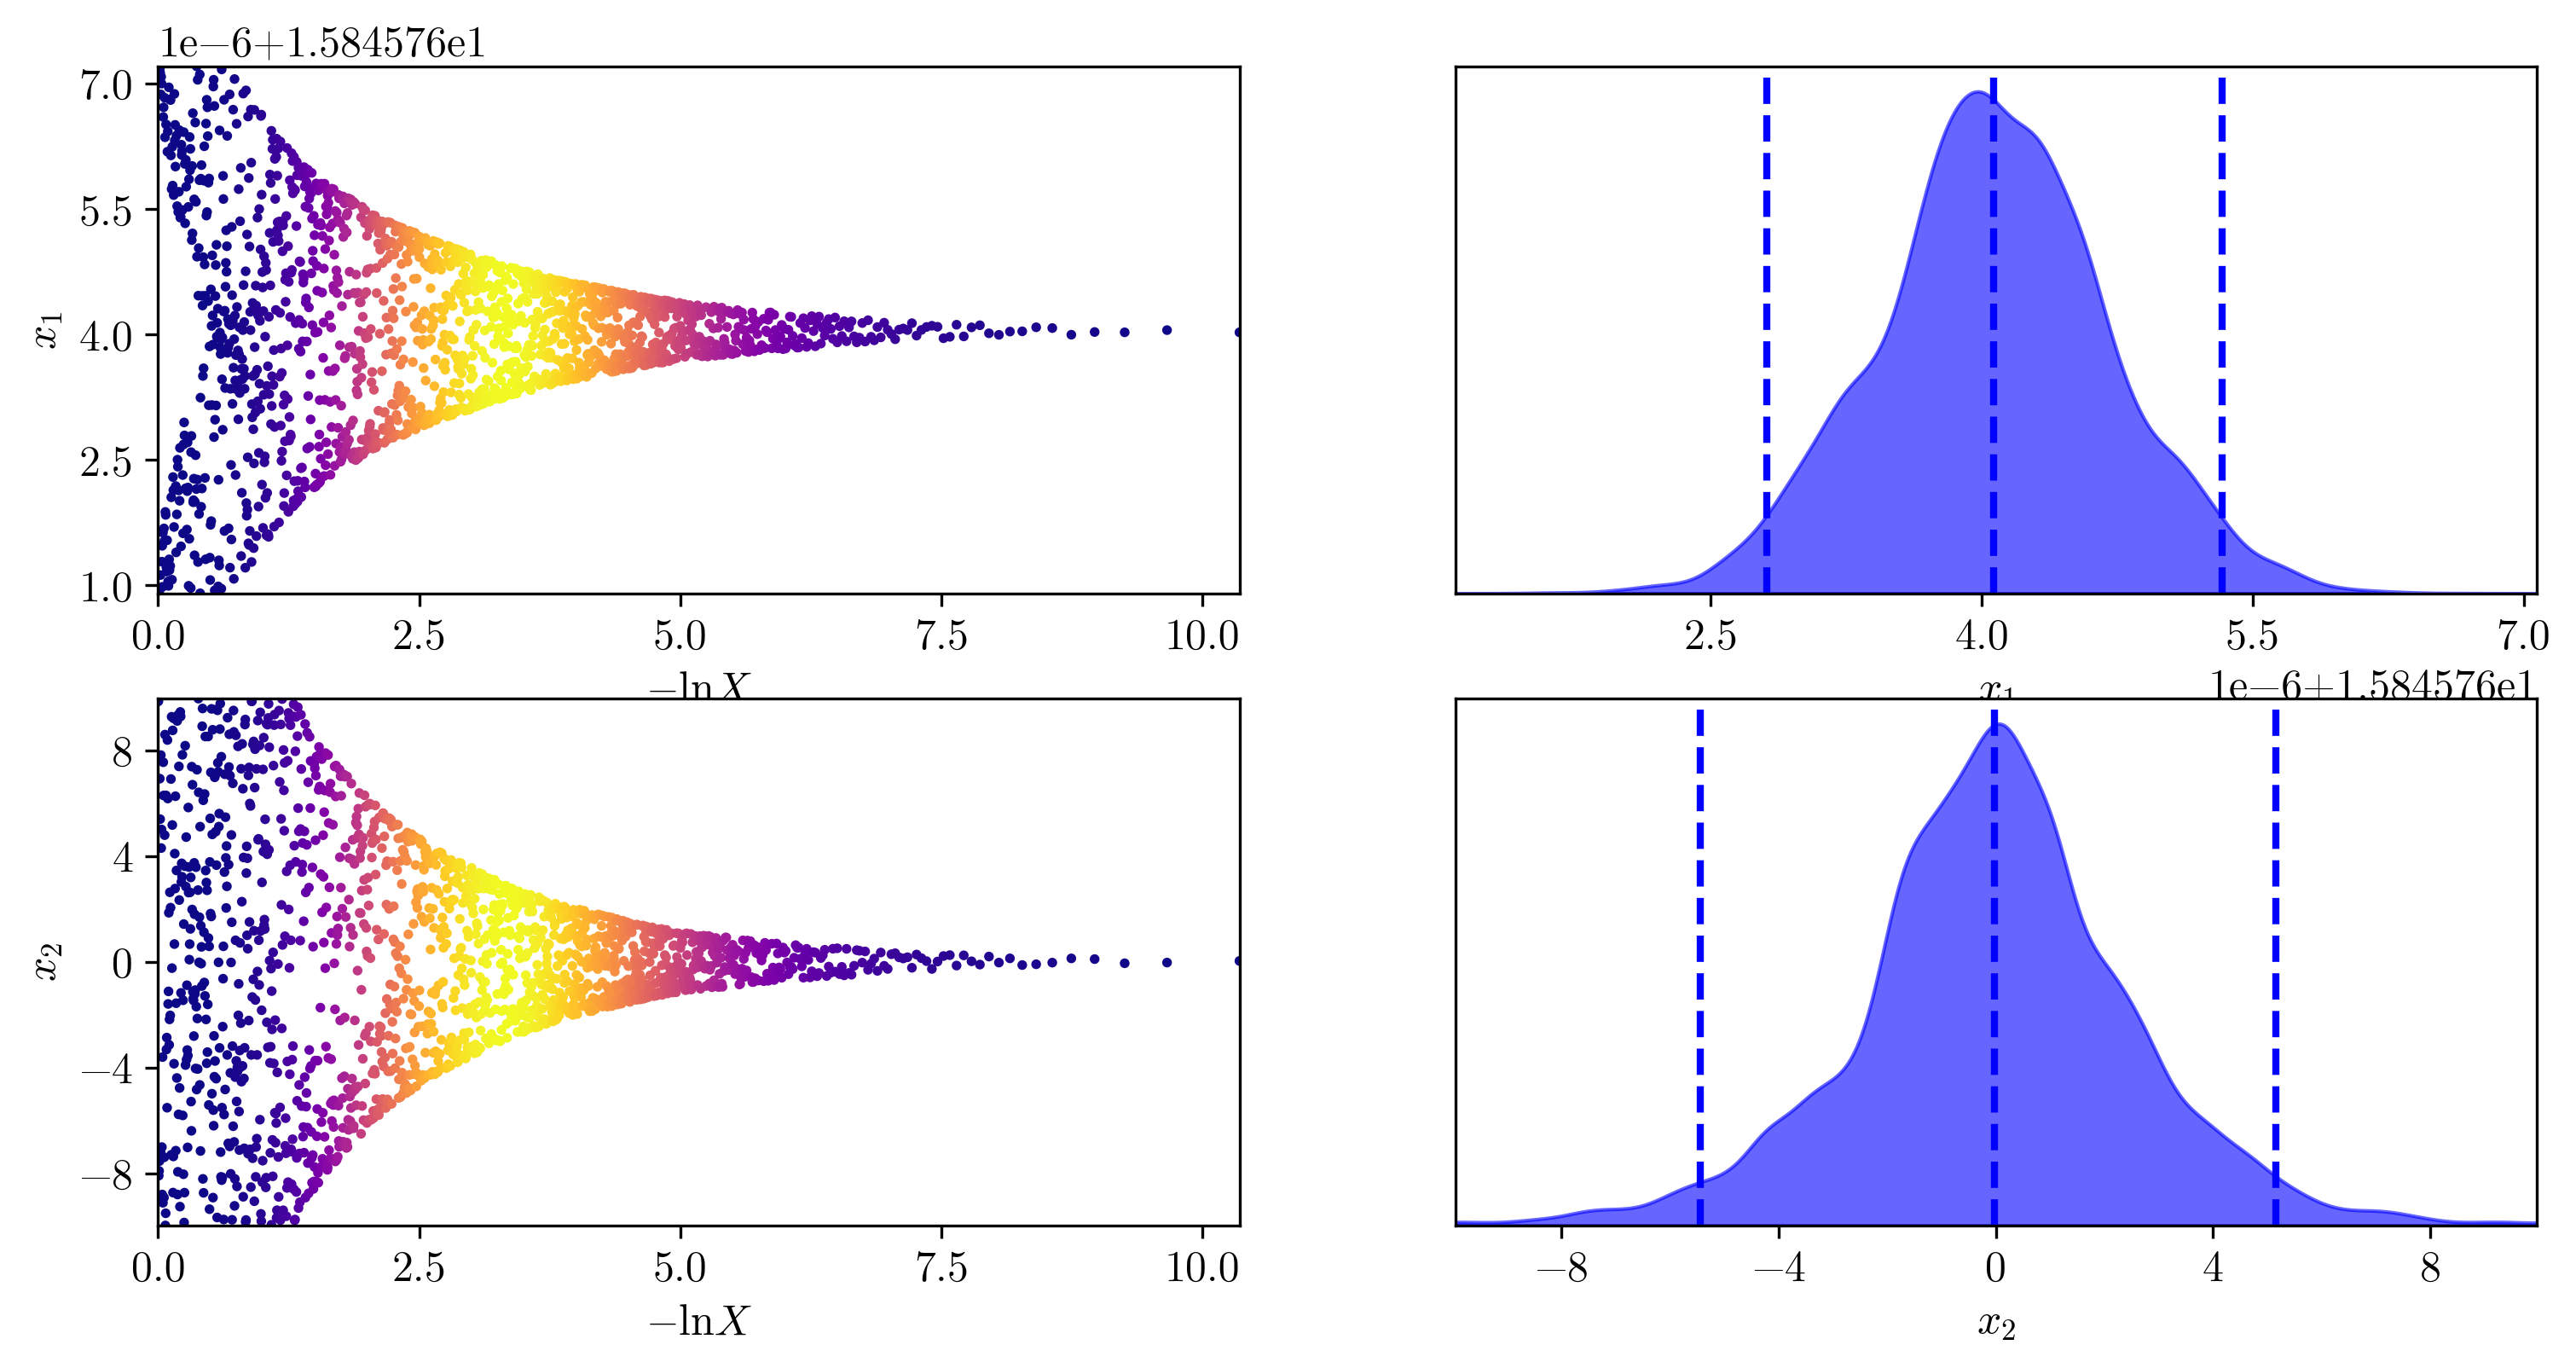

In [245]:
tfig, taxes = dyplot.traceplot(results)

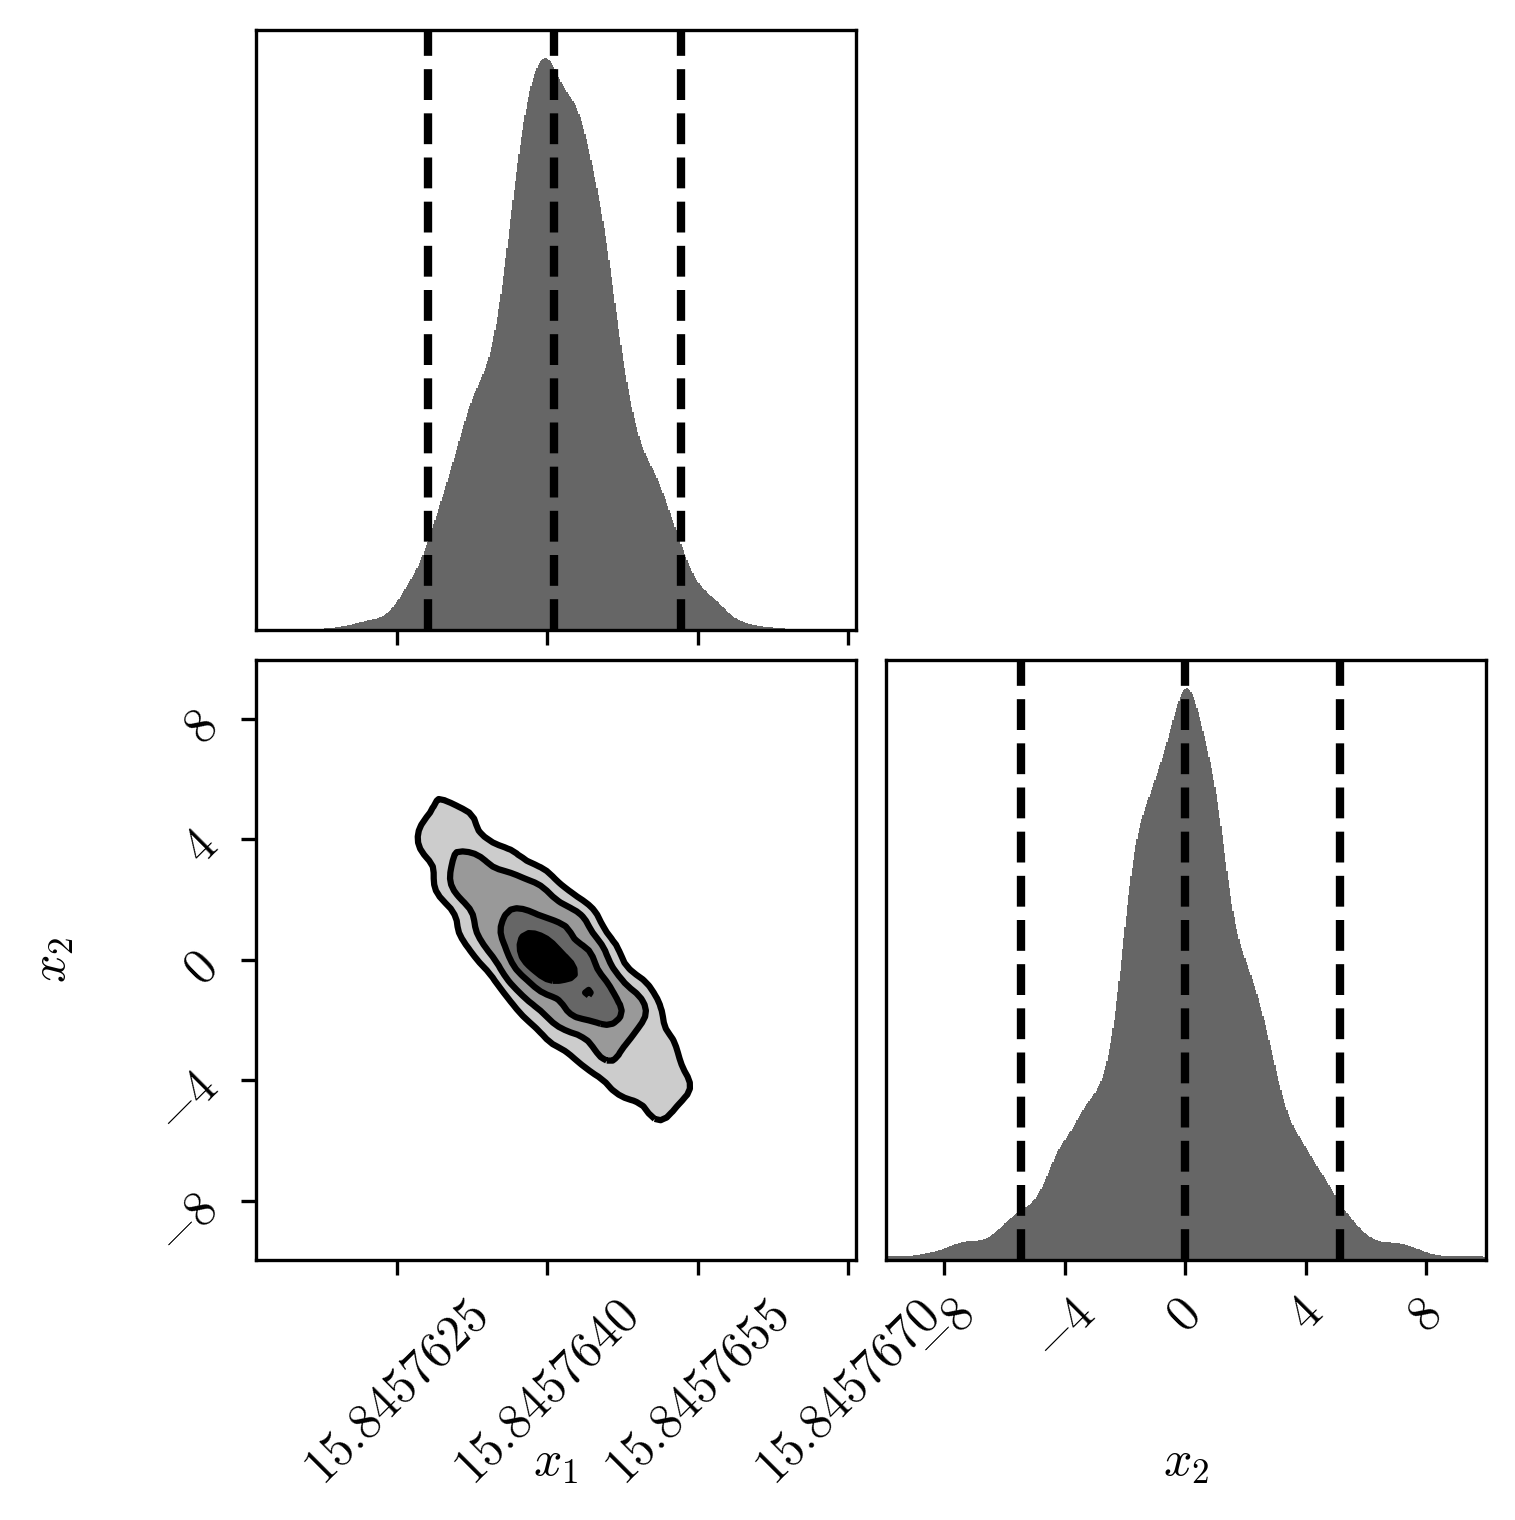

In [246]:
cfig, caxes = dyplot.cornerplot(results)

Check the likelihood directly

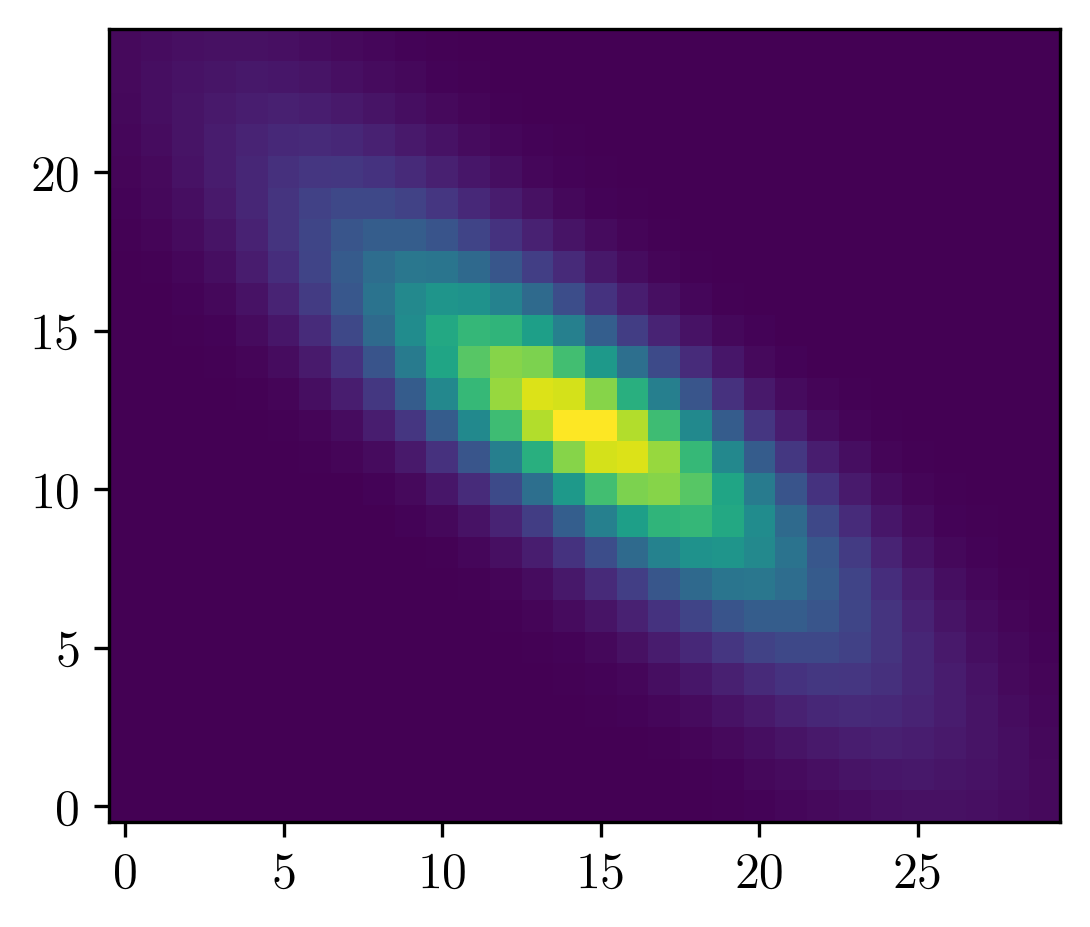

In [184]:
M_chirps = jnp.linspace(vb_s.M_chirp * (1 - 1e-7), vb_s.M_chirp * (1 + 1e-7), 30)
tT_cs = jnp.linspace(-6, 6, 25)
M_chirp_mg, tT_c_mg = jnp.meshgrid(M_chirps, tT_cs)
logLs = jax.vmap(logL_dynesty)(
    jnp.stack((M_chirp_mg, tT_c_mg), axis=-1).reshape(-1, 2)
).reshape(M_chirp_mg.shape)

plt.imshow(jnp.exp(logLs), origin="lower")

#### Dynamic dress

In [5]:
import dynesty
from dynesty import plotting as dyplot

In [69]:
m_1 = jnp.array(1e3 * MSUN)
m_2 = jnp.array(1 * MSUN)
rho_s = jnp.array(226 * MSUN / PC**3)
gamma_s = jnp.array(7 / 3)
f_l = jnp.array(0.022621092492458004)  # Hz
f_c = get_f_isco(m_1)
dd_s = make_dynamic_dress(m_1, m_2, rho_s, gamma_s)


@jax.jit
def logL_dynesty(x):
    gamma_s, M_chirp_MSUN, tT_c = x
    dd_h = DynamicDress(
        gamma_s,
        dd_s.c_f,  # fixed
        M_chirp_MSUN * MSUN,
        dd_s.q,  # fixed
        dd_s.Phi_c,  # fixed
        tT_c,
        dL_iota=dd_s.dL_iota  # value doesn't matter
    )
    f_c_h = get_f_isco(get_m_1(dd_h.M_chirp, dd_h.q))
    return loglikelihood(dd_h, f_c_h, "d", dd_s, f_c, "d", f_l, f_c)

In [82]:
logL_dynesty(jnp.array([dd_s.gamma_s, dd_s.M_chirp / MSUN, dd_s.tT_c]))

Buffer(42.2626203, dtype=float64)

In [83]:
logL_dynesty(jnp.array([dd_s.gamma_s, dd_s.M_chirp / MSUN, dd_s.tT_c]))

Buffer(42.2626203, dtype=float64)

In [89]:
r_gamma_s = 1e-3
r_M_chirp_MSUN = 1e-6
d_tT_c = 14

labels = (
    r"$\gamma_s$",
    r"$\mathcal{M}$ [M$_\odot$]",
    r"$\tilde{t}_c$ [s]"
)

def ptform(u):
    return jnp.array([
        dd_s.gamma_s * (1 + r_gamma_s * (2 * u[0] - 1)),
        dd_s.M_chirp / MSUN * (1 + r_M_chirp_MSUN * (2 * u[1] - 1)),
        d_tT_c * (2 * u[2] - 1)
    ])

Run sampler

In [90]:
sampler = dynesty.NestedSampler(logL_dynesty, ptform, 3, nlive=300)
sampler.run_nested()
results = sampler.results

2727it [01:39, 27.31it/s, +300 | bound: 9 | nc: 1 | ncall: 14694 | eff(%): 20.600 | loglstar:   -inf < 42.242 <    inf | logz: 34.400 +/-  0.215 | dlogz:  0.001 >  0.309]


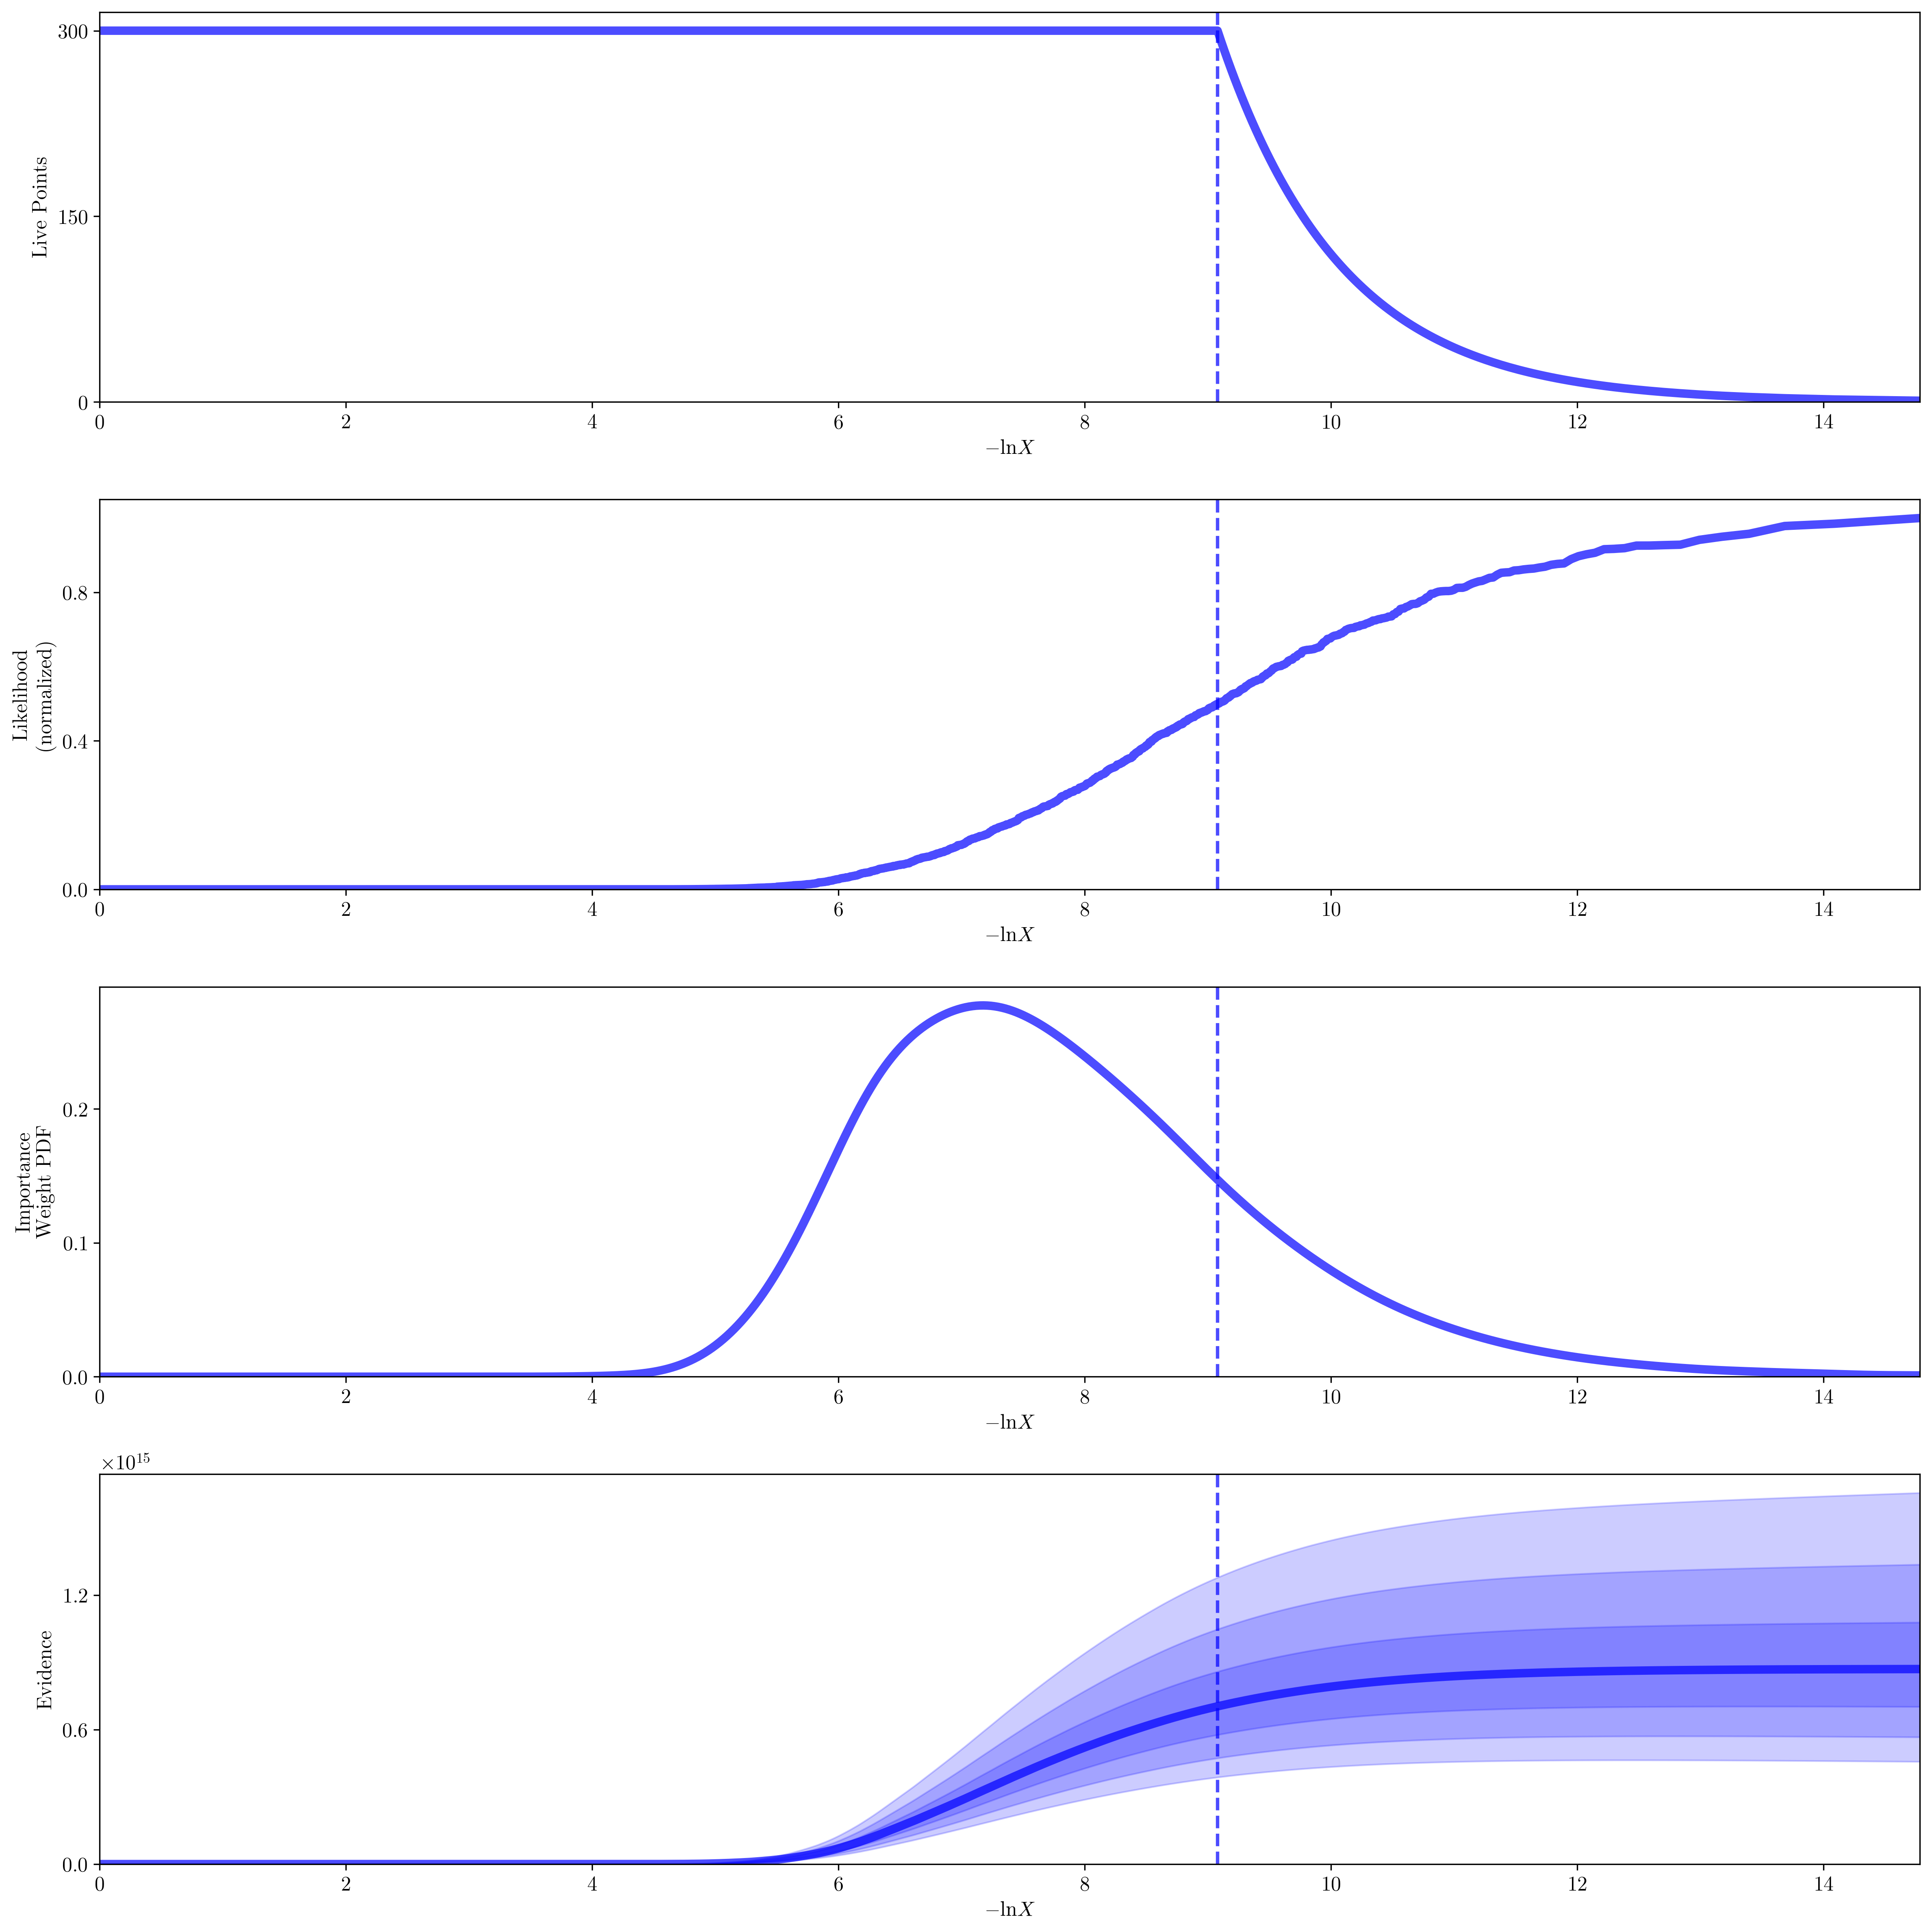

In [91]:
rfig, raxes = dyplot.runplot(results)
rfig.tight_layout()

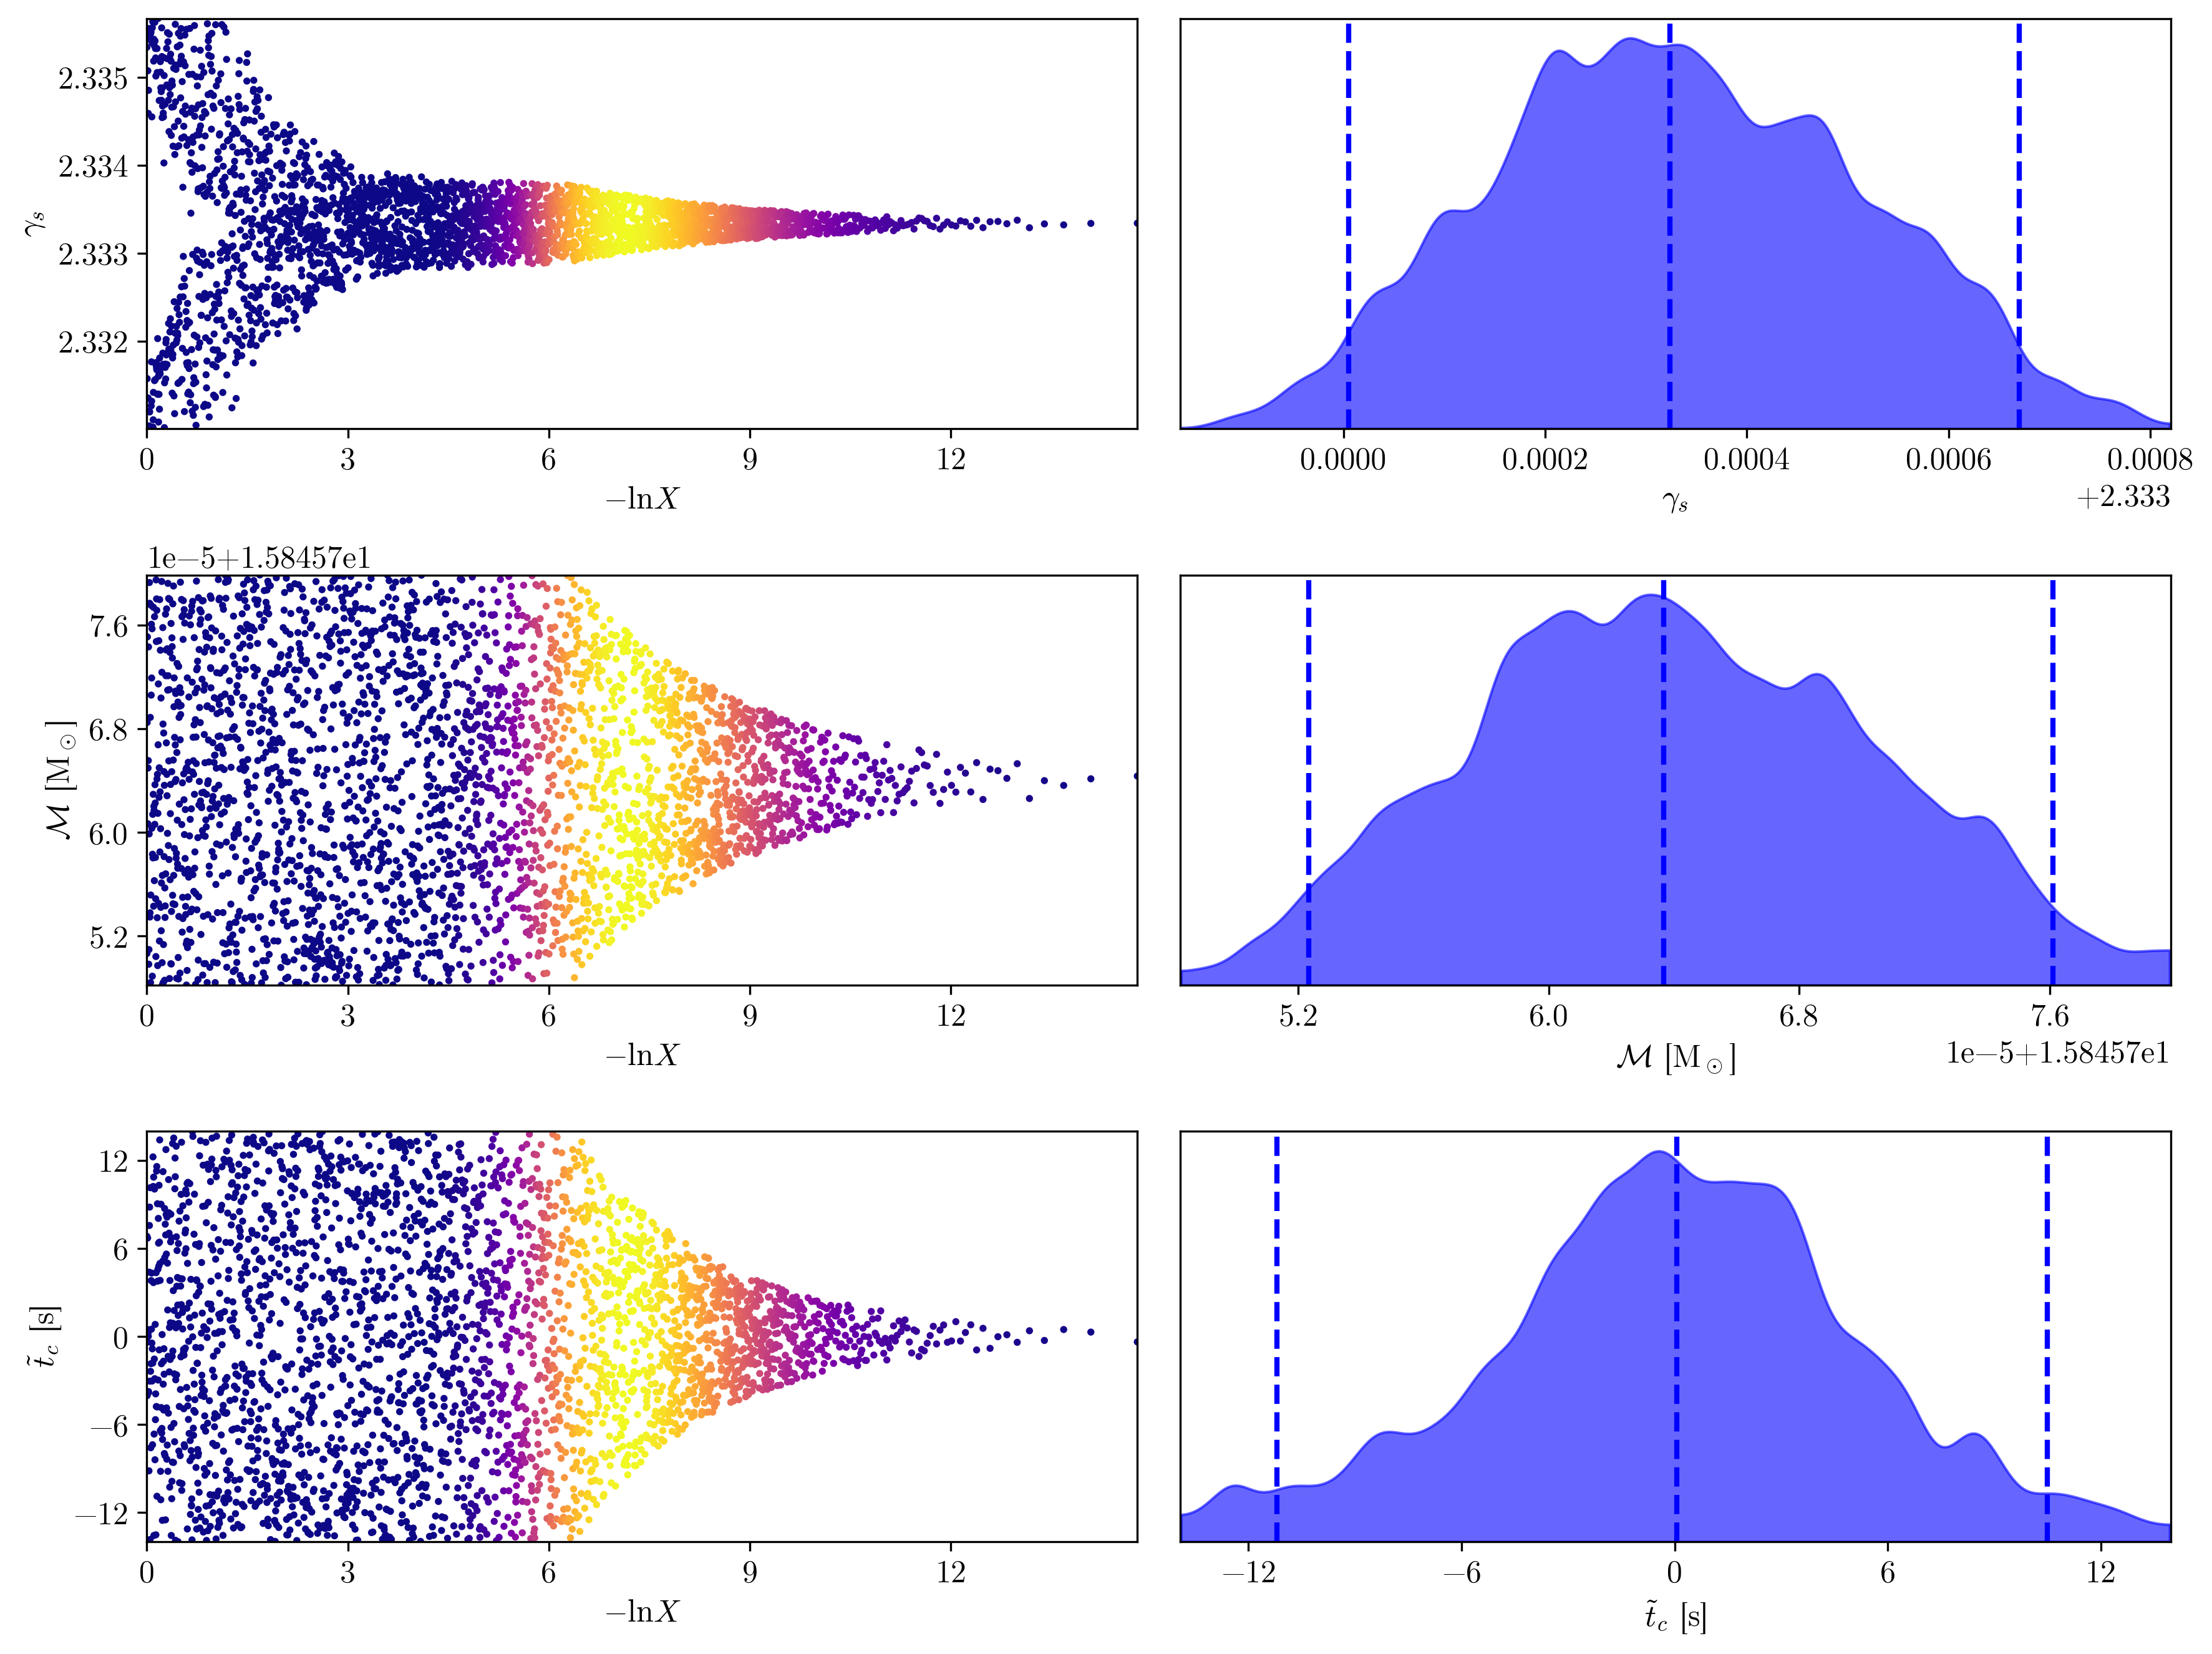

In [92]:
tfig, taxes = dyplot.traceplot(results, labels=labels)
tfig.tight_layout()

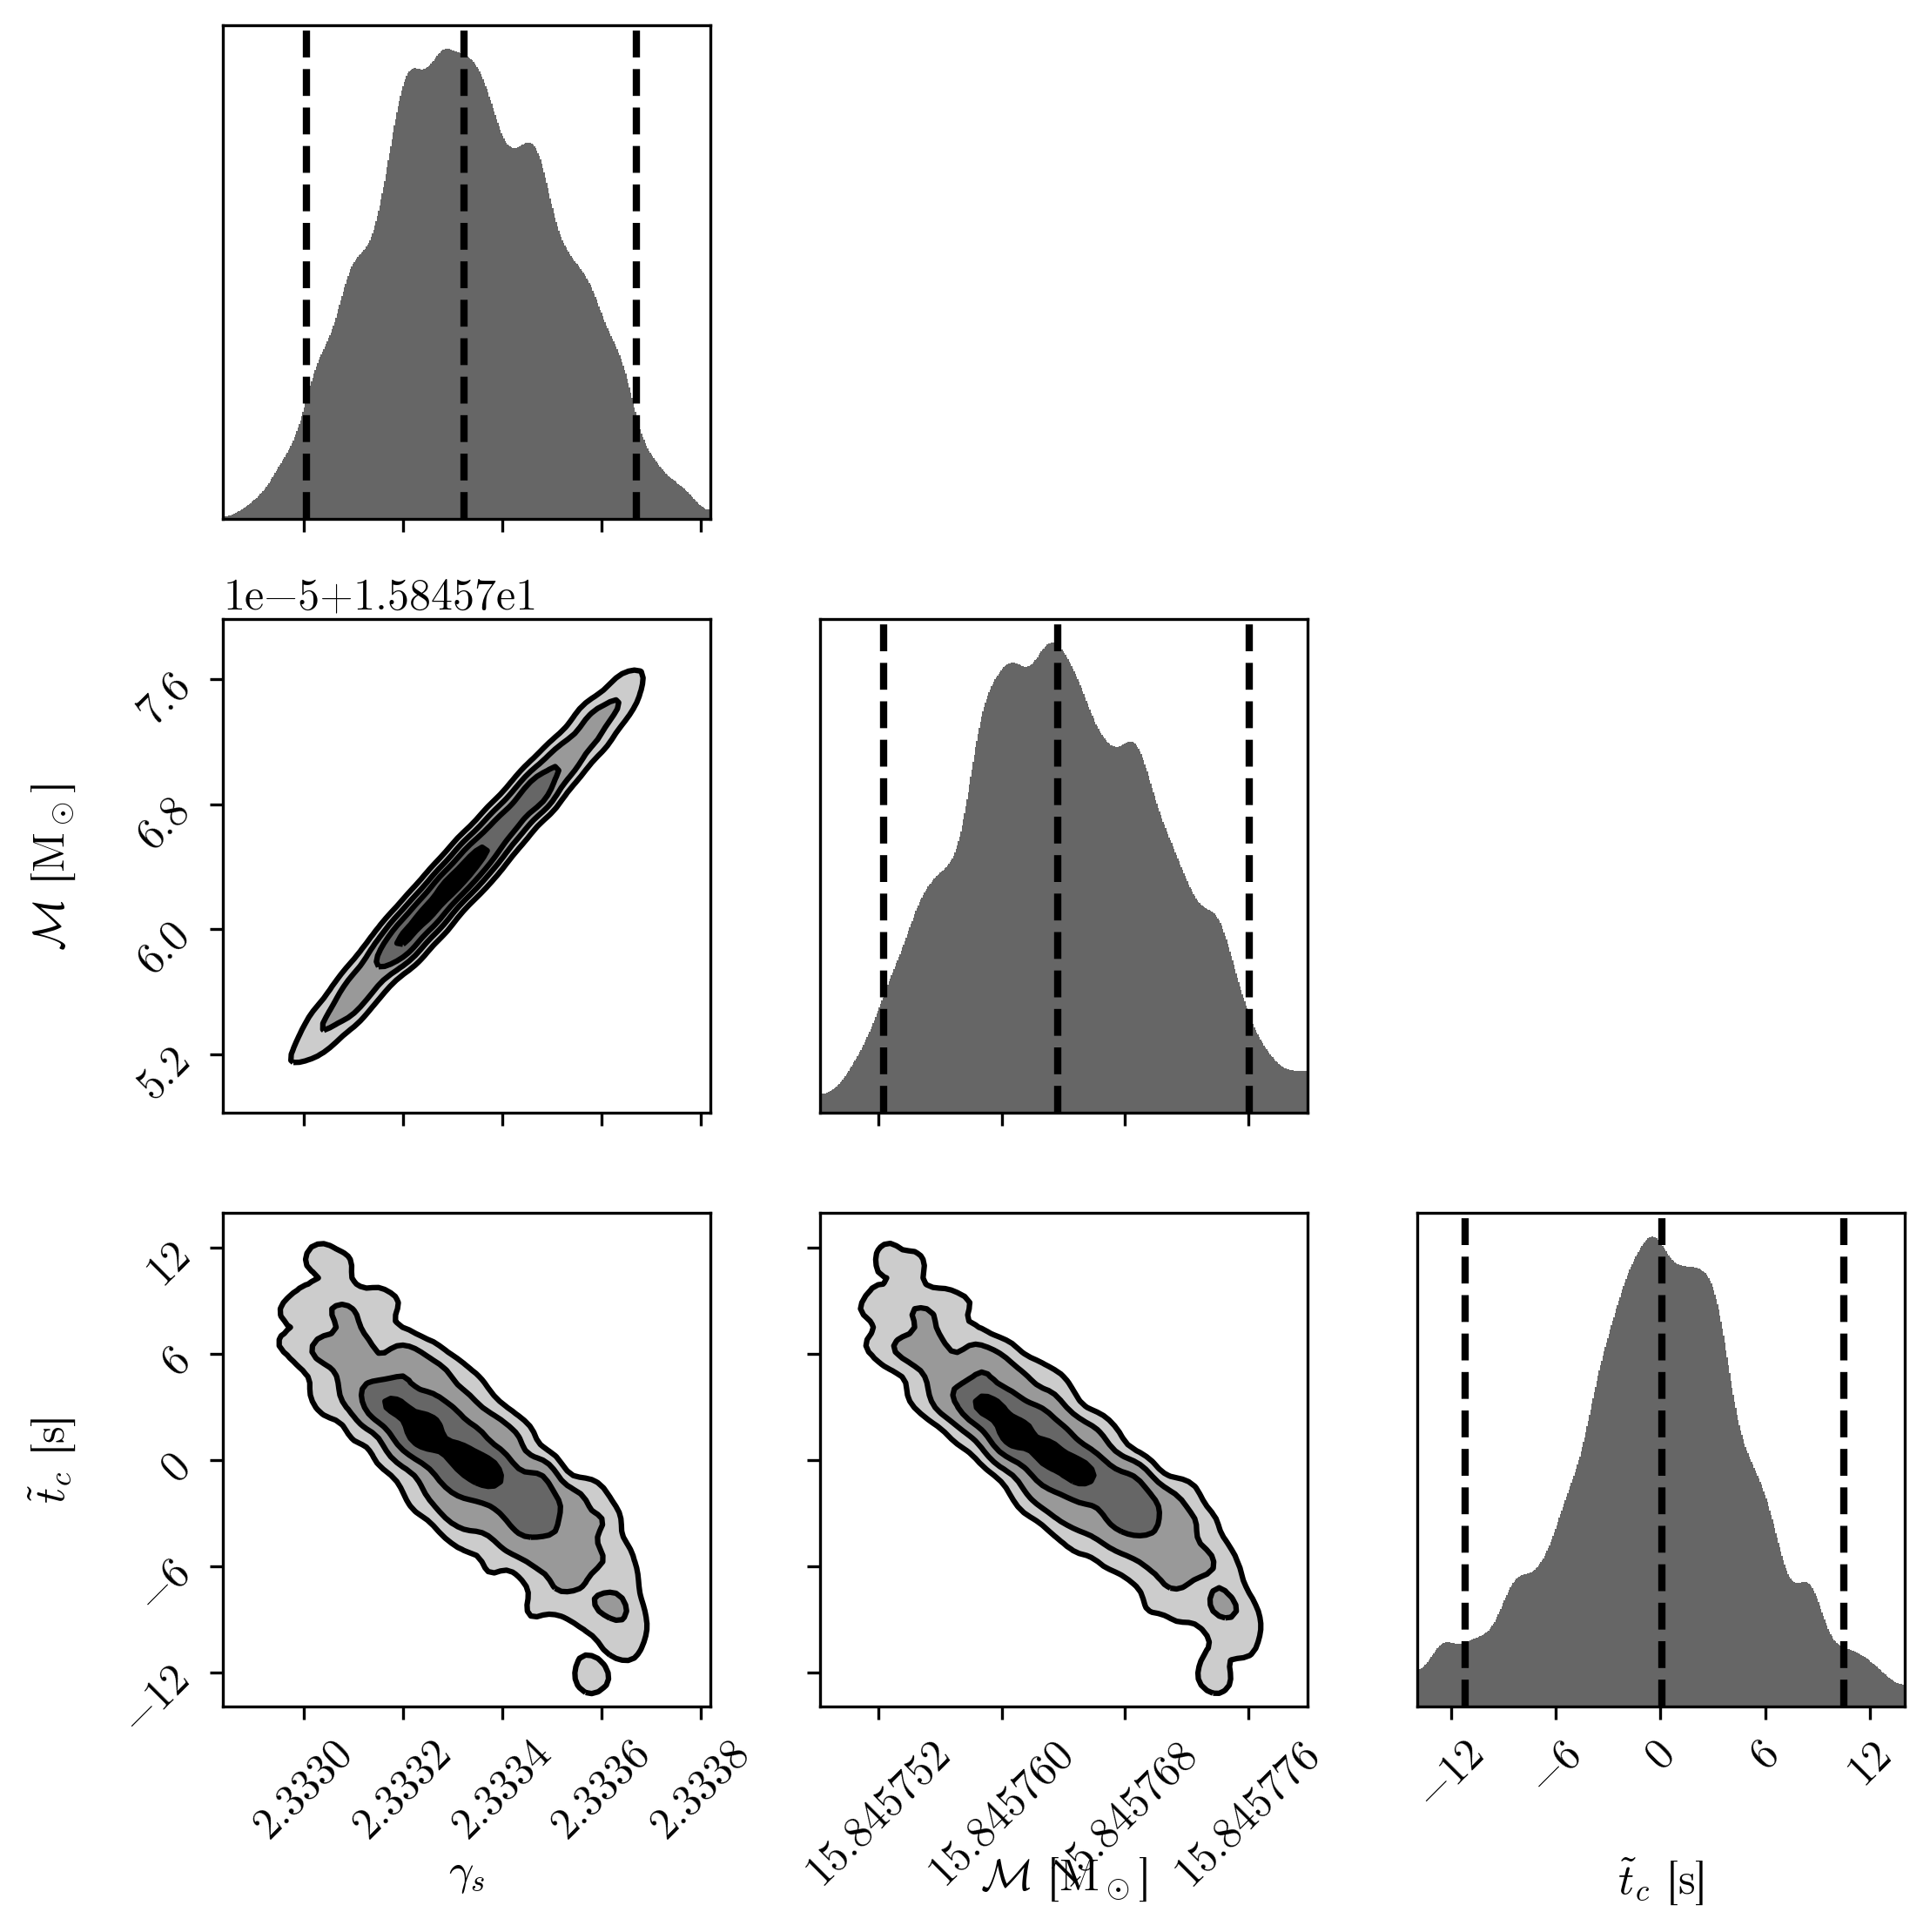

In [93]:
cfig, caxes = dyplot.cornerplot(results, labels=labels, smooth=0.025)
cfig.tight_layout()

Plot actual likelihood

In [61]:
import numpy as np
from corner import corner


gamma_ss = jnp.linspace(
    dd_s.gamma_s * (1 - 5e-4),
    dd_s.gamma_s * (1 + 5e-4),
    4
)
M_chirp_MSUNs = jnp.linspace(
    dd_s.M_chirp / MSUN * (1 - 1e-7),
    dd_s.M_chirp / MSUN * (1 + 1e-7),
    5
)
tT_cs = jnp.linspace(-10, 10, 6)

logLs = np.zeros((len(gamma_ss), len(M_chirp_MSUNs), len(tT_cs)))
for i in range(logLs.shape[0]):
    for j in range(logLs.shape[1]):
        for k in range(logLs.shape[2]):
            logLs[i, j, k] = logL_dynesty(
                jnp.array([gamma_ss[i], M_chirp_MSUNs[j], tT_cs[k]])
            )

In [67]:
n_samples = 25000
xs = ptform(np.random.rand(3, n_samples)).T
logLs = jnp.stack([logL_dynesty(x) for x in xs])
weights = jnp.exp(logLs)

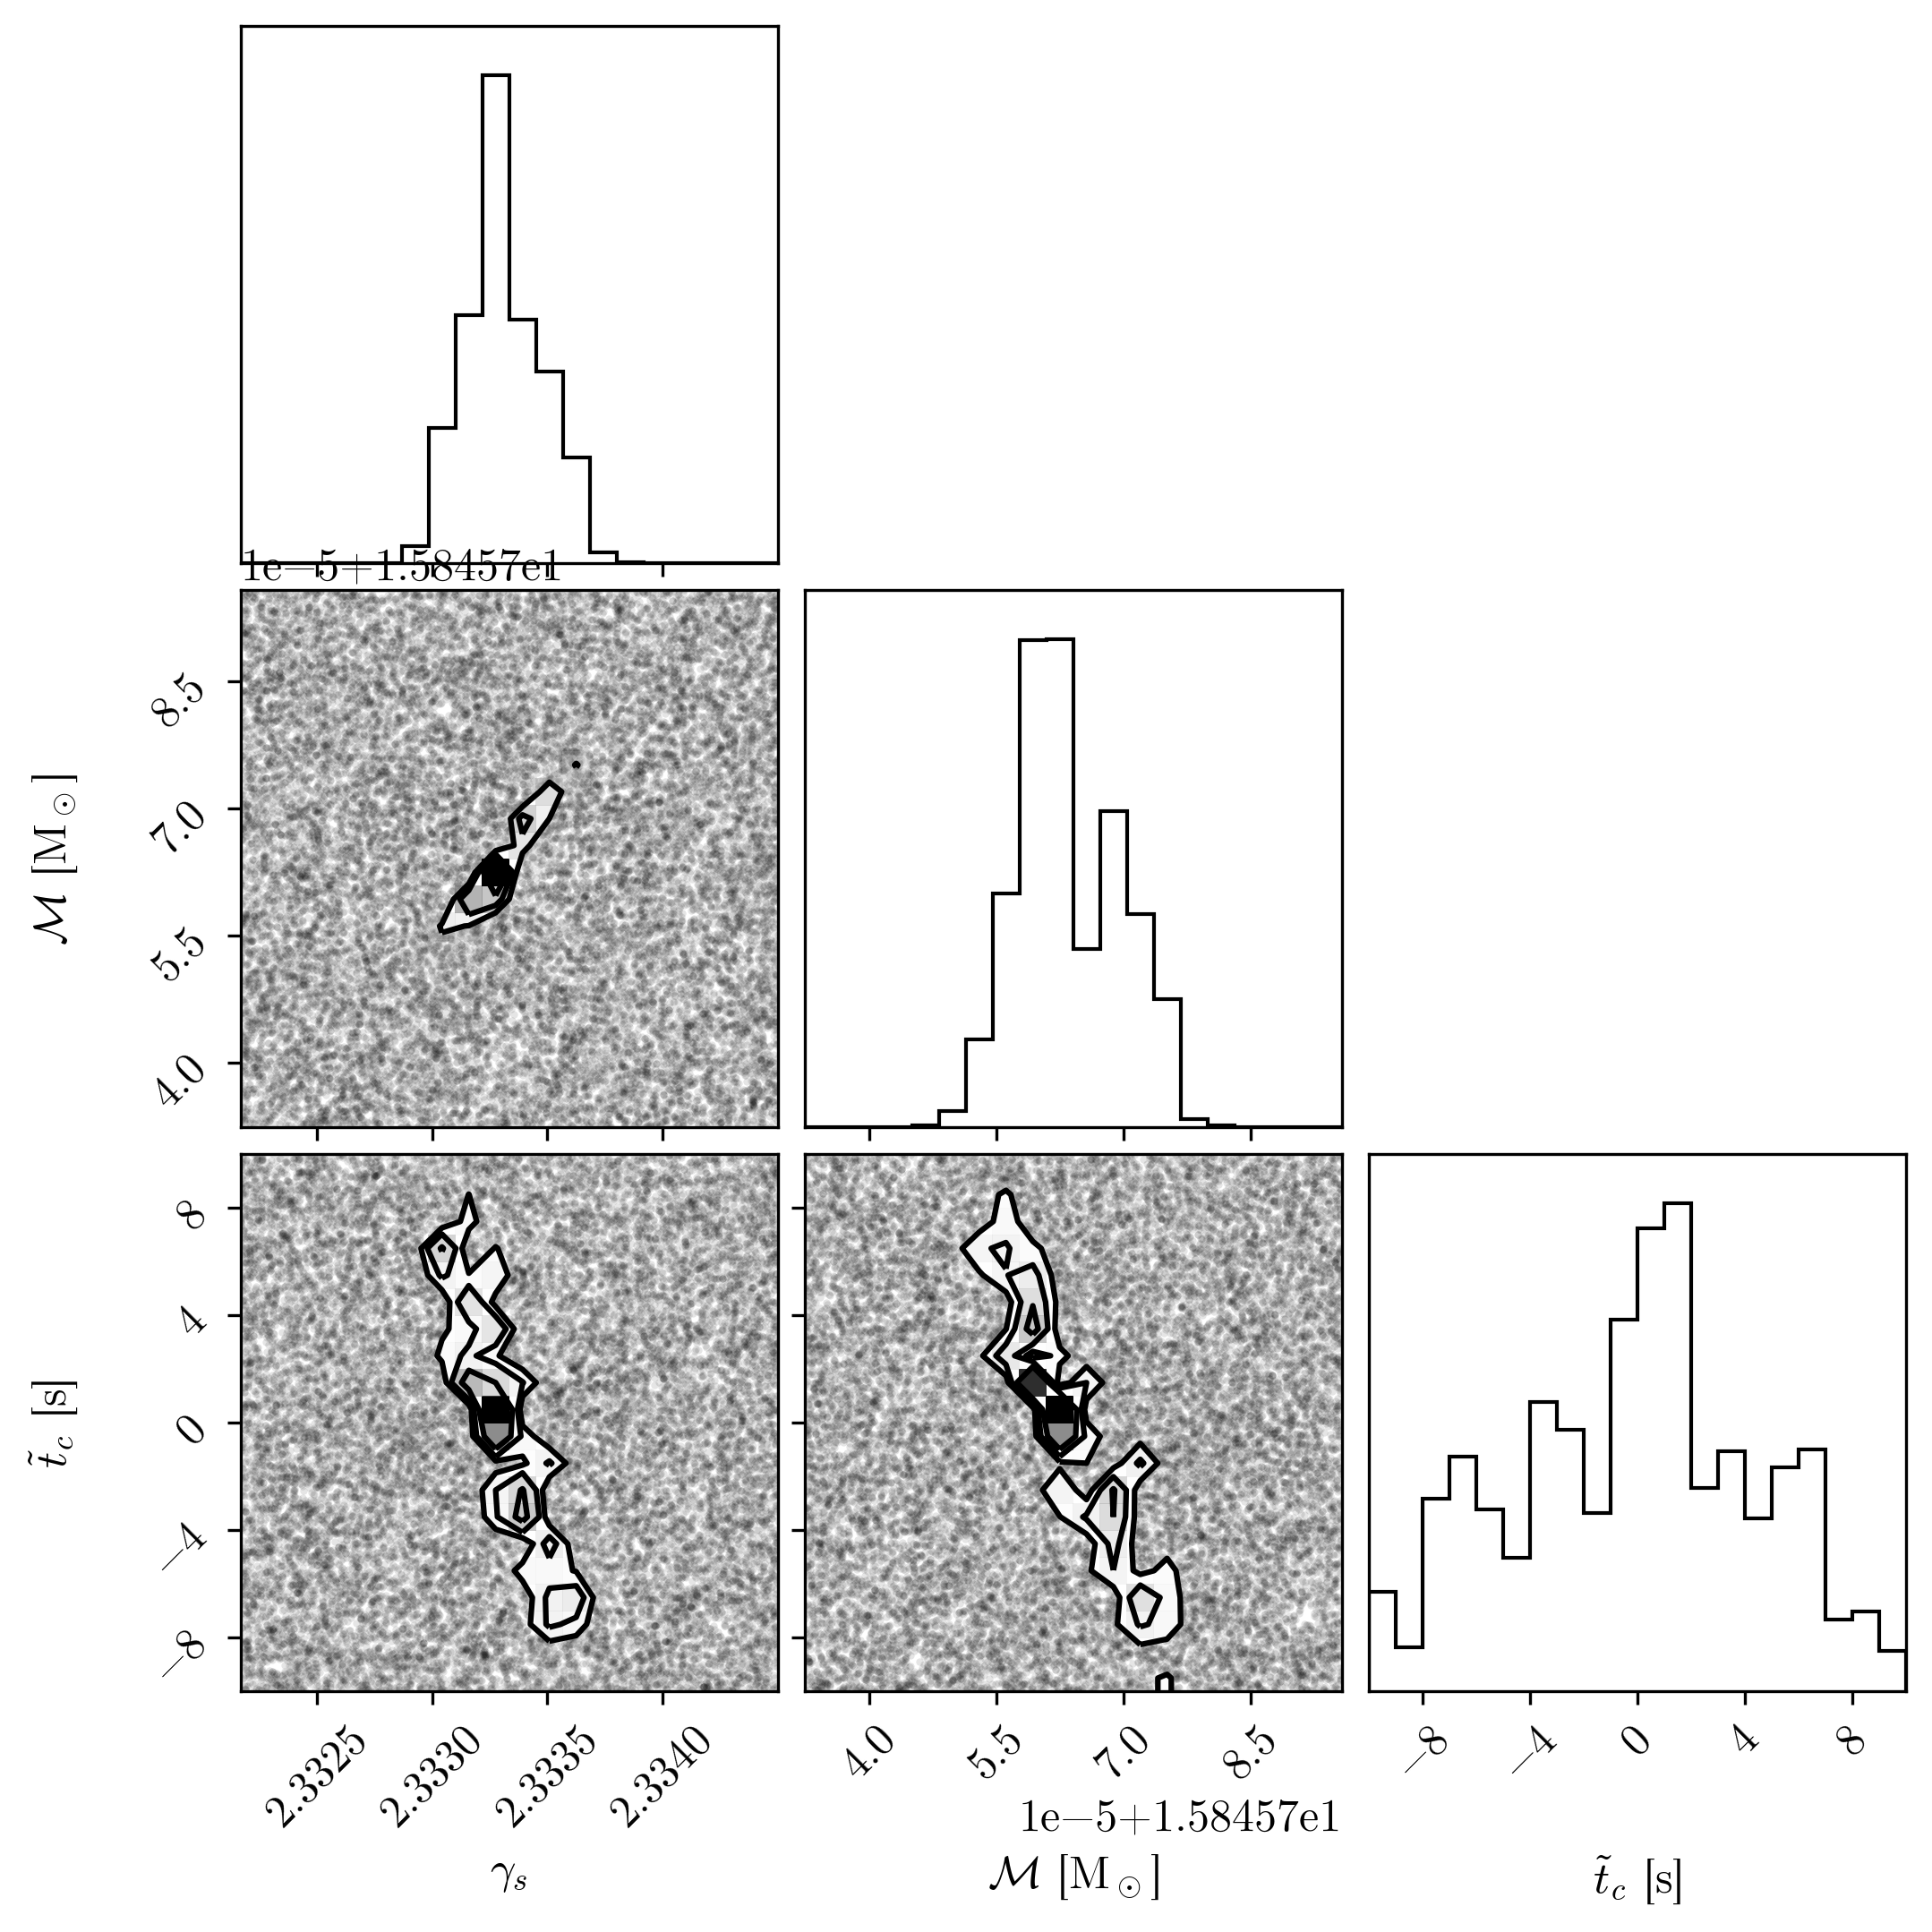

In [68]:
corner(
    np.array(xs),
    labels=(r"$\gamma_s$", r"$\mathcal{M}$ [M$_\odot$]", r"$\tilde{t}_c$ [s]"),
    weights=np.array(weights)
);

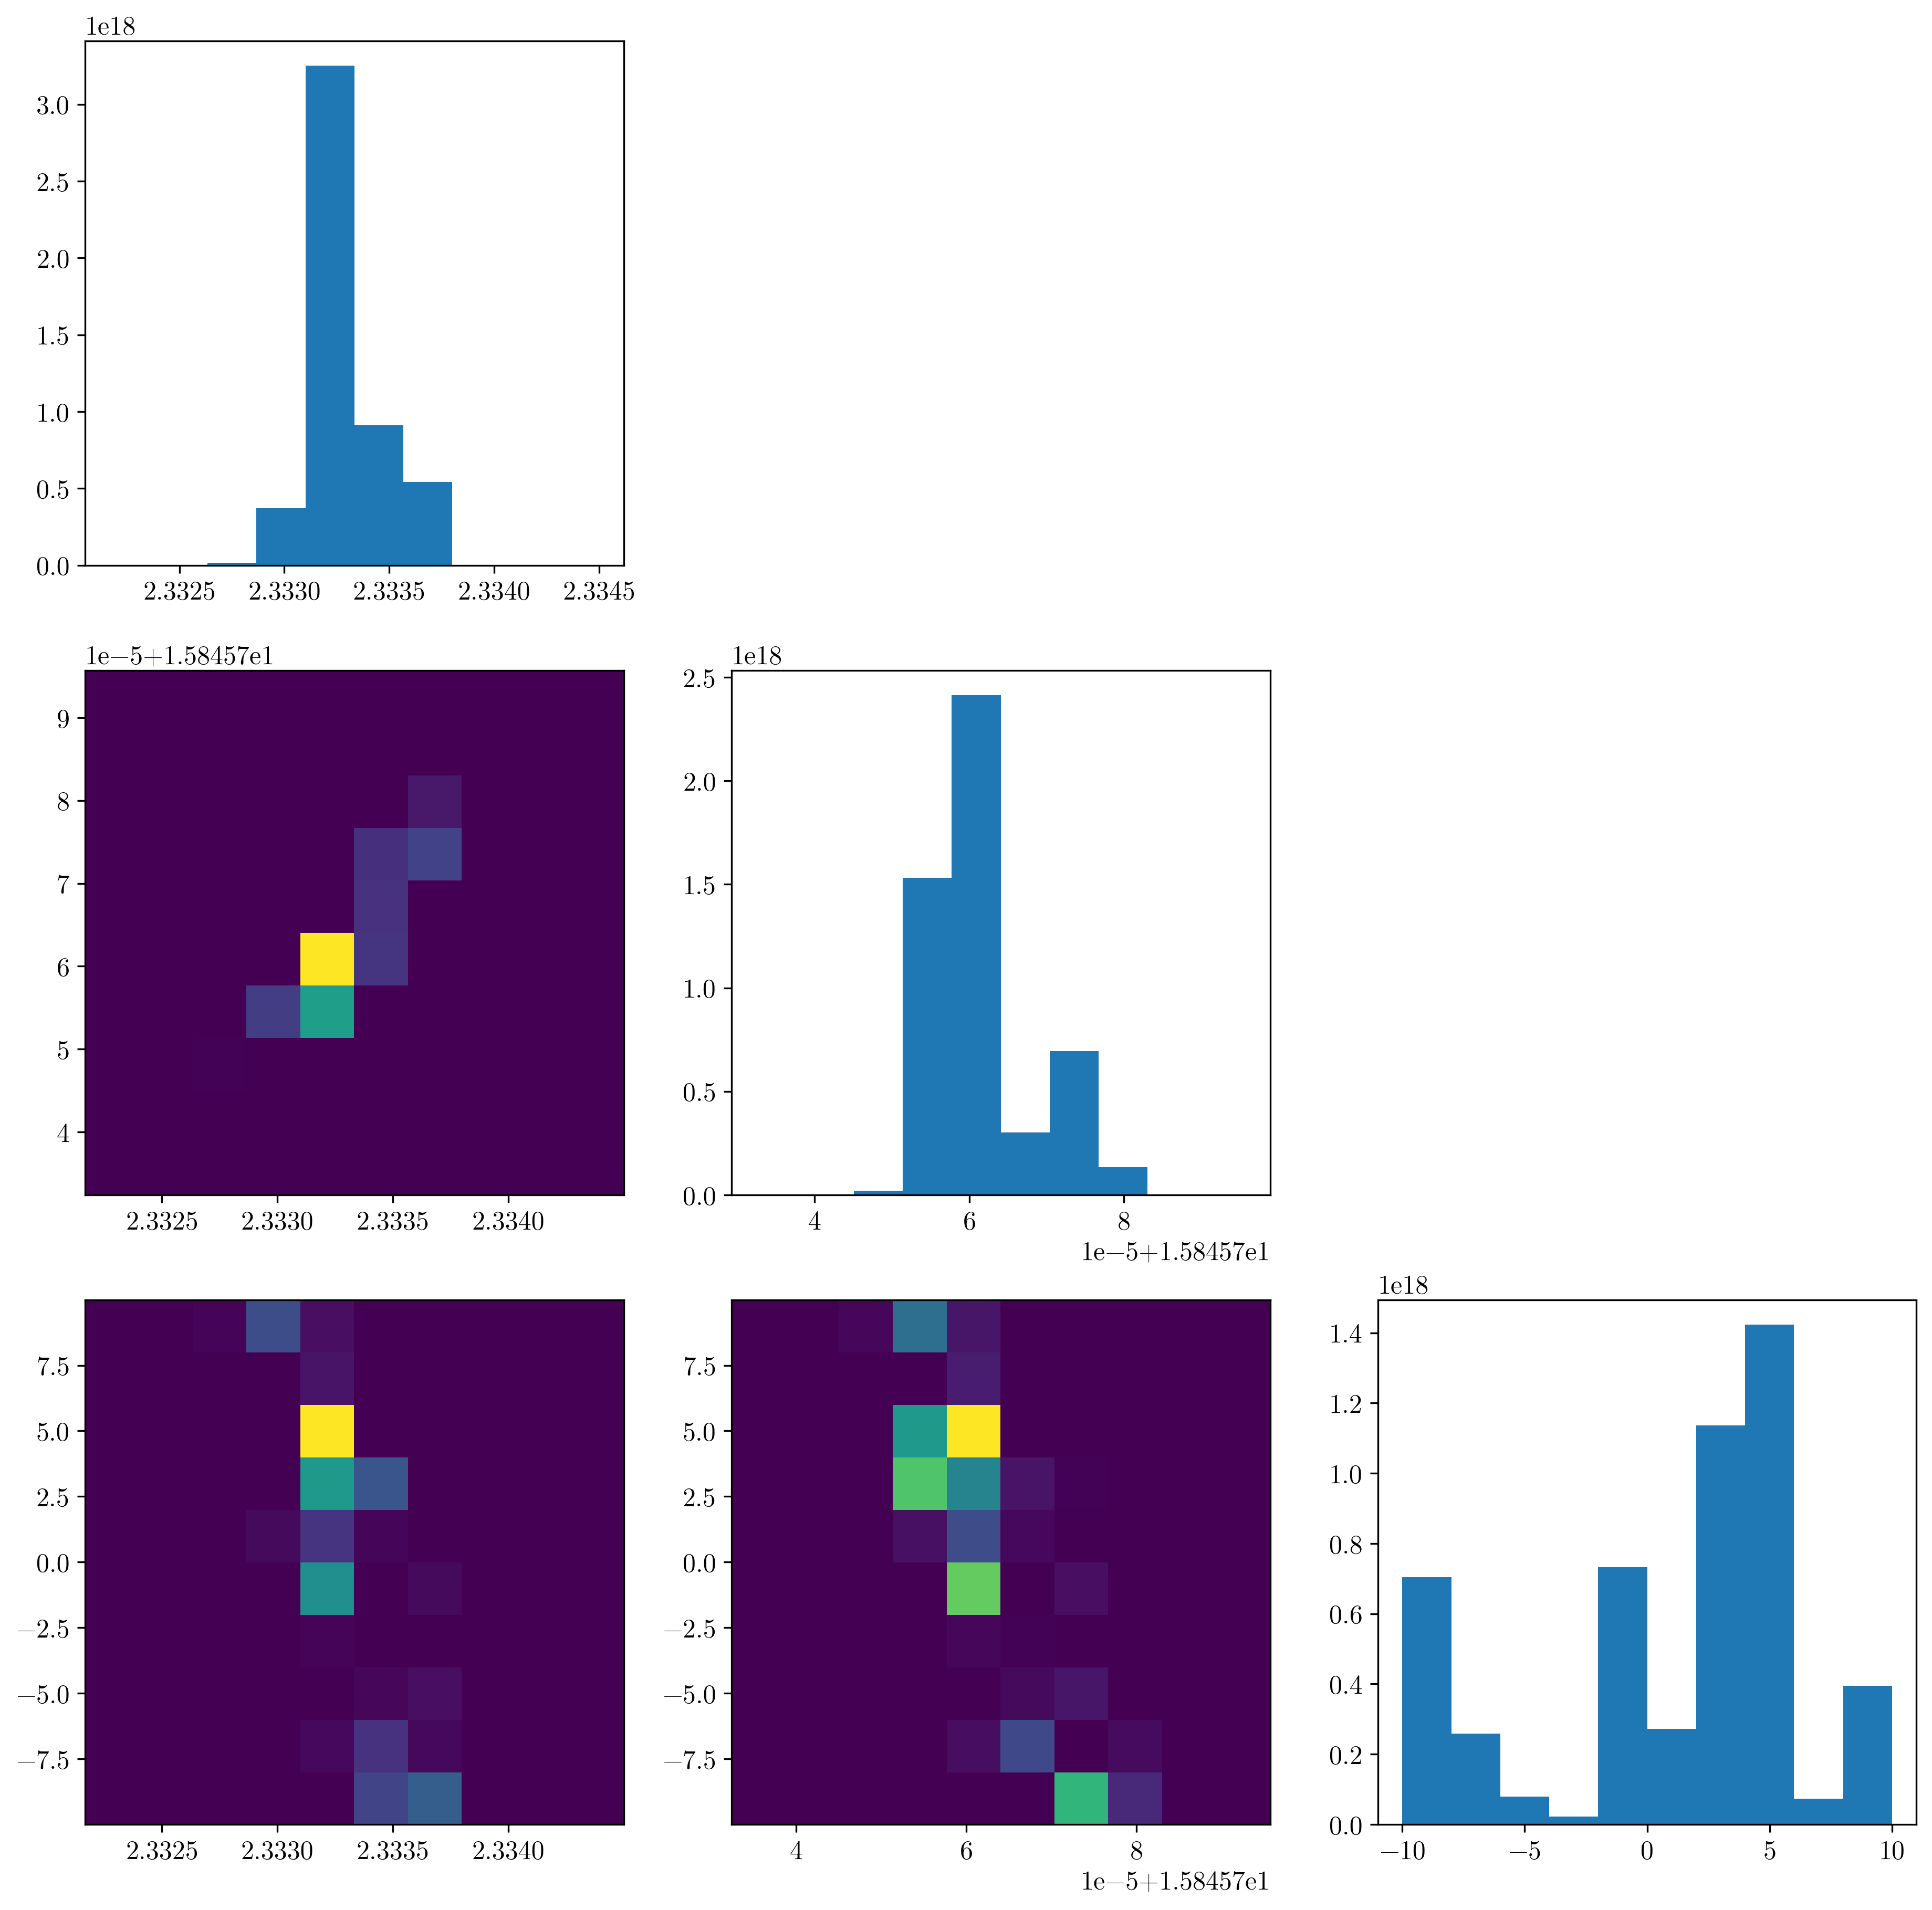

In [65]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        if i == j:
            ax.hist(xs[:, i], weights=weights)
        elif j < i:
            ax.hist2d(xs[:, j], xs[:, i], weights=weights)
        else:
            ax.axis("off")

### Interpolate `hyp2f1`

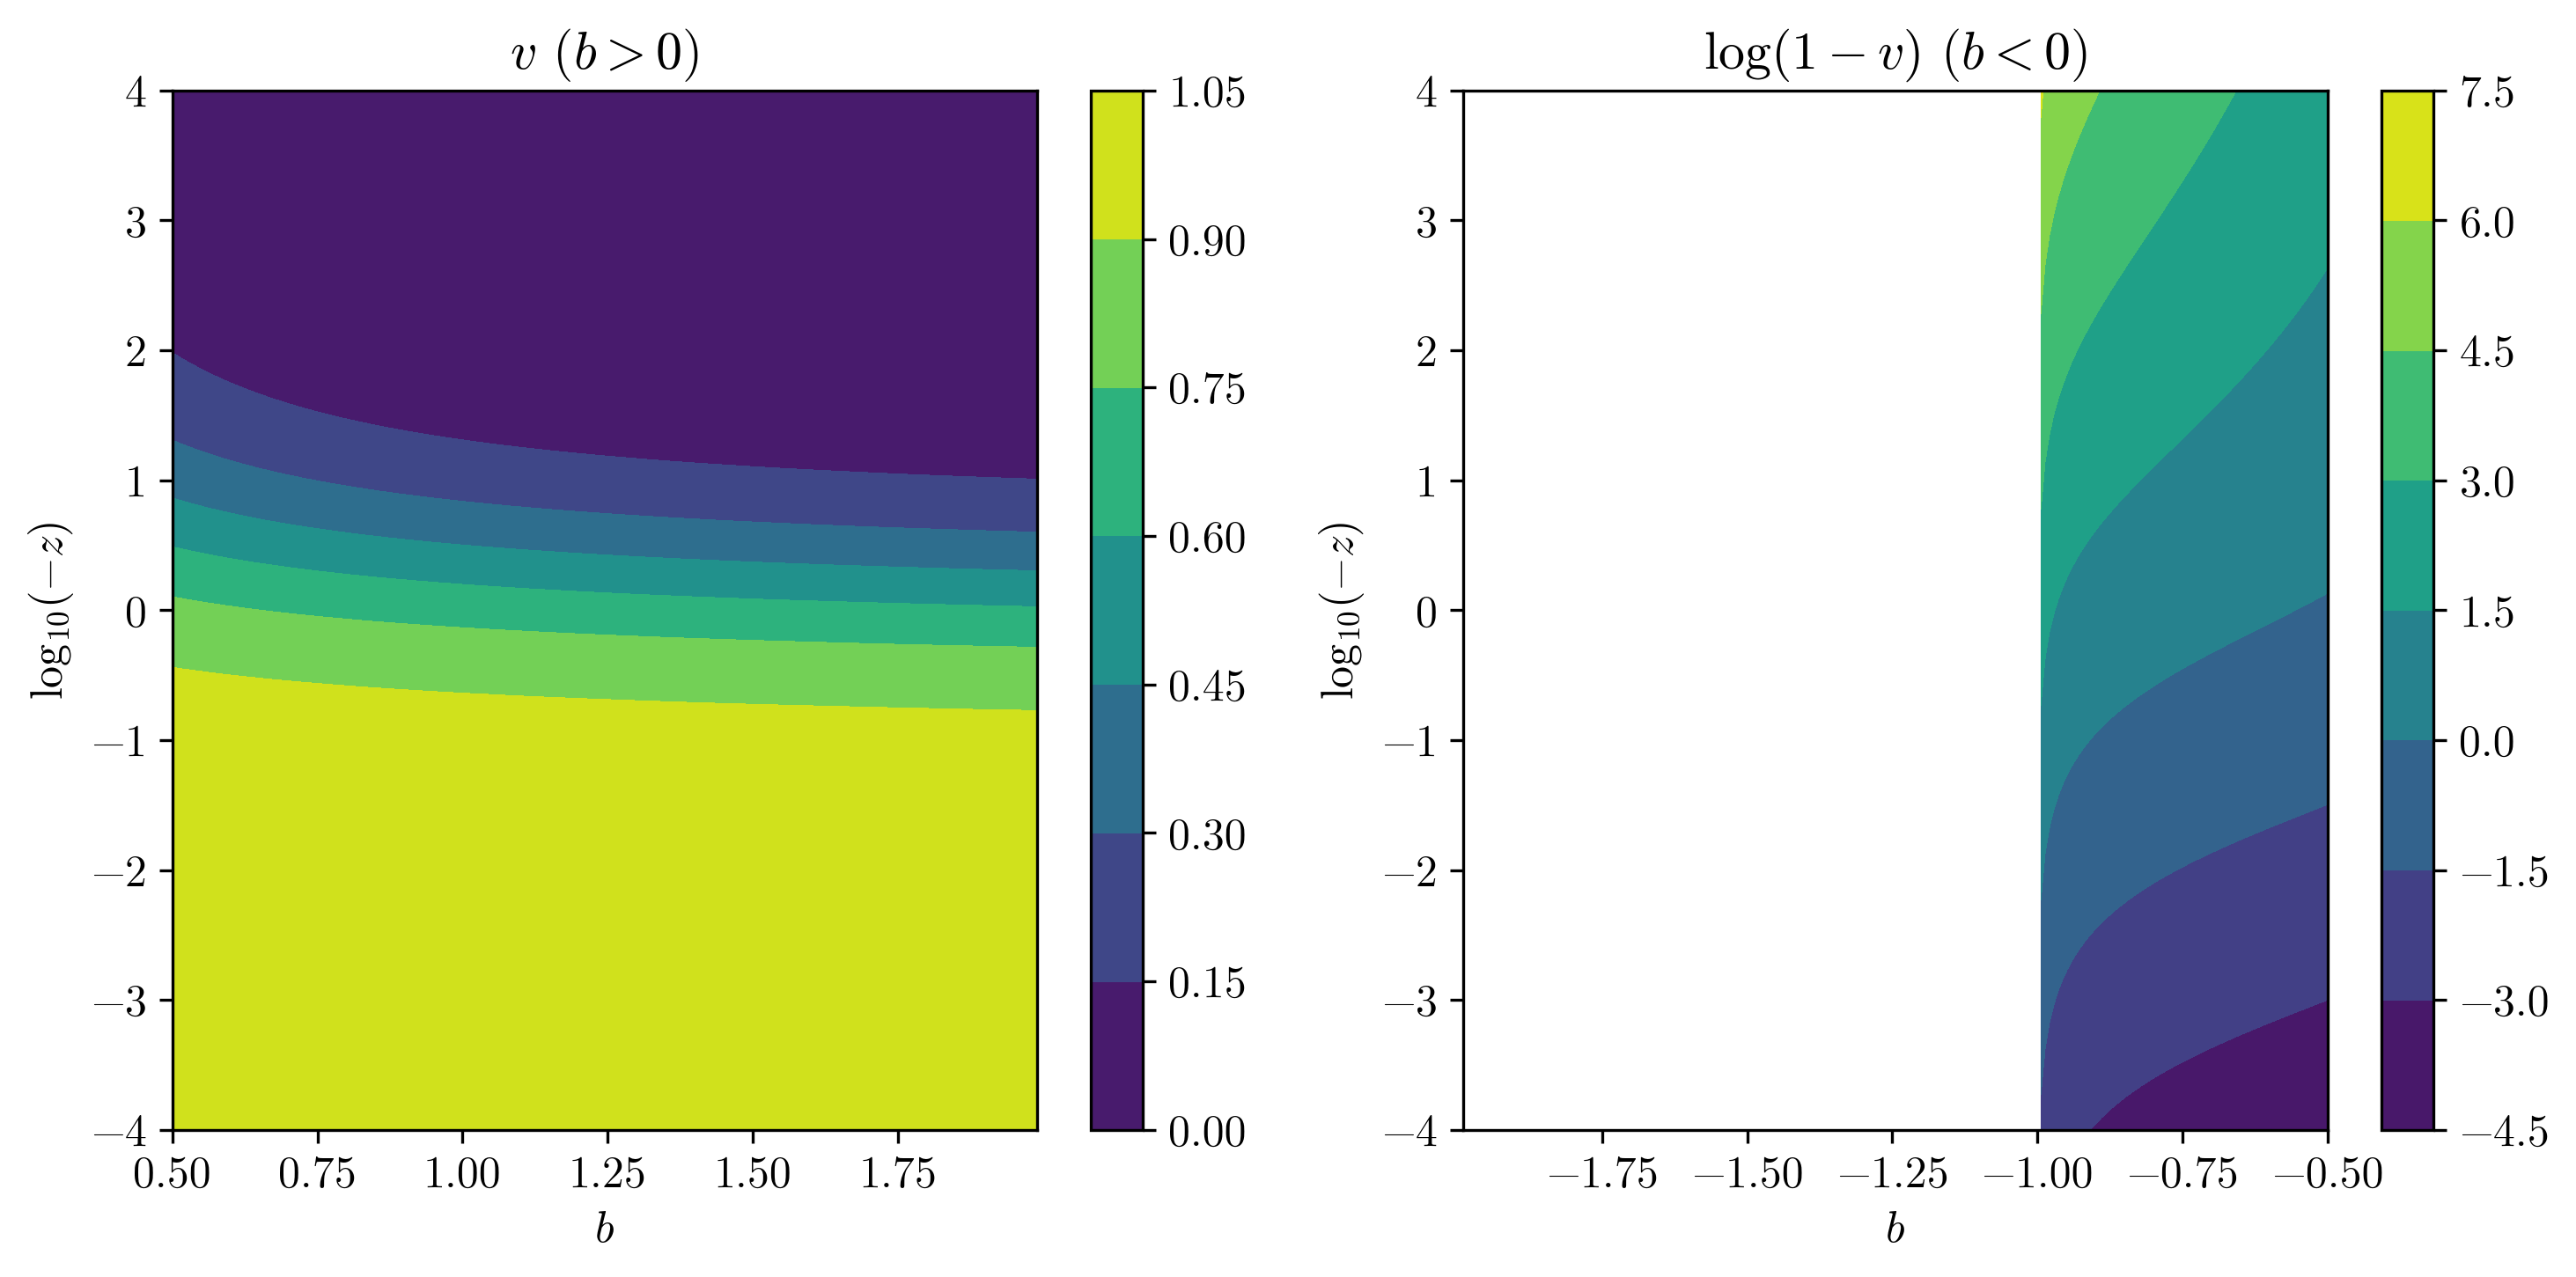

In [19]:
def plot_hypgeom():
    plt.figure(figsize=(10, 5))

    bs = jnp.linspace(0.5, 1.99, 200)  # +/-
    log10_abs_zs = jnp.linspace(-4, 4, 180)
    b_mg, log10_abs_z_mg = jnp.meshgrid(bs, log10_abs_zs, indexing="ij")
    vals = hypgeom_scipy(b_mg, -10**log10_abs_z_mg)
    plt.subplot(1, 2, 1)
    plt.contourf(b_mg, log10_abs_z_mg, vals)
    plt.colorbar()
    plt.xlabel(r"$b$")
    plt.ylabel(r"$\log_{10}(-z)$")
    plt.title(r"$v$ ($b > 0$)")

    bs = -jnp.linspace(0.5, 1.99, 200)  # +/-
    log10_abs_zs = jnp.linspace(-4, 4, 180)
    b_mg, log10_abs_z_mg = jnp.meshgrid(bs, log10_abs_zs, indexing="ij")
    vals = hypgeom_scipy(b_mg, -10**log10_abs_z_mg)
    plt.subplot(1, 2, 2)
    plt.contourf(b_mg, log10_abs_z_mg, jnp.log10(-1 + vals))
    plt.colorbar()
    plt.xlabel(r"$b$")
    plt.ylabel(r"$\log_{10}(-z)$")
    plt.title(r"$\log(1 - v)$ ($b < 0$)")

    plt.tight_layout()


plot_hypgeom()

## Torch

In [4]:
from binary_torch import *

In [14]:
import torch
from scipy.special import betainc
from torchinterp1d.torchinterp1d import Interp1d


interp = Interp1d()

In [26]:
get_xi(torch.tensor(1.).unsqueeze(0))[0]

tensor([0.8183])

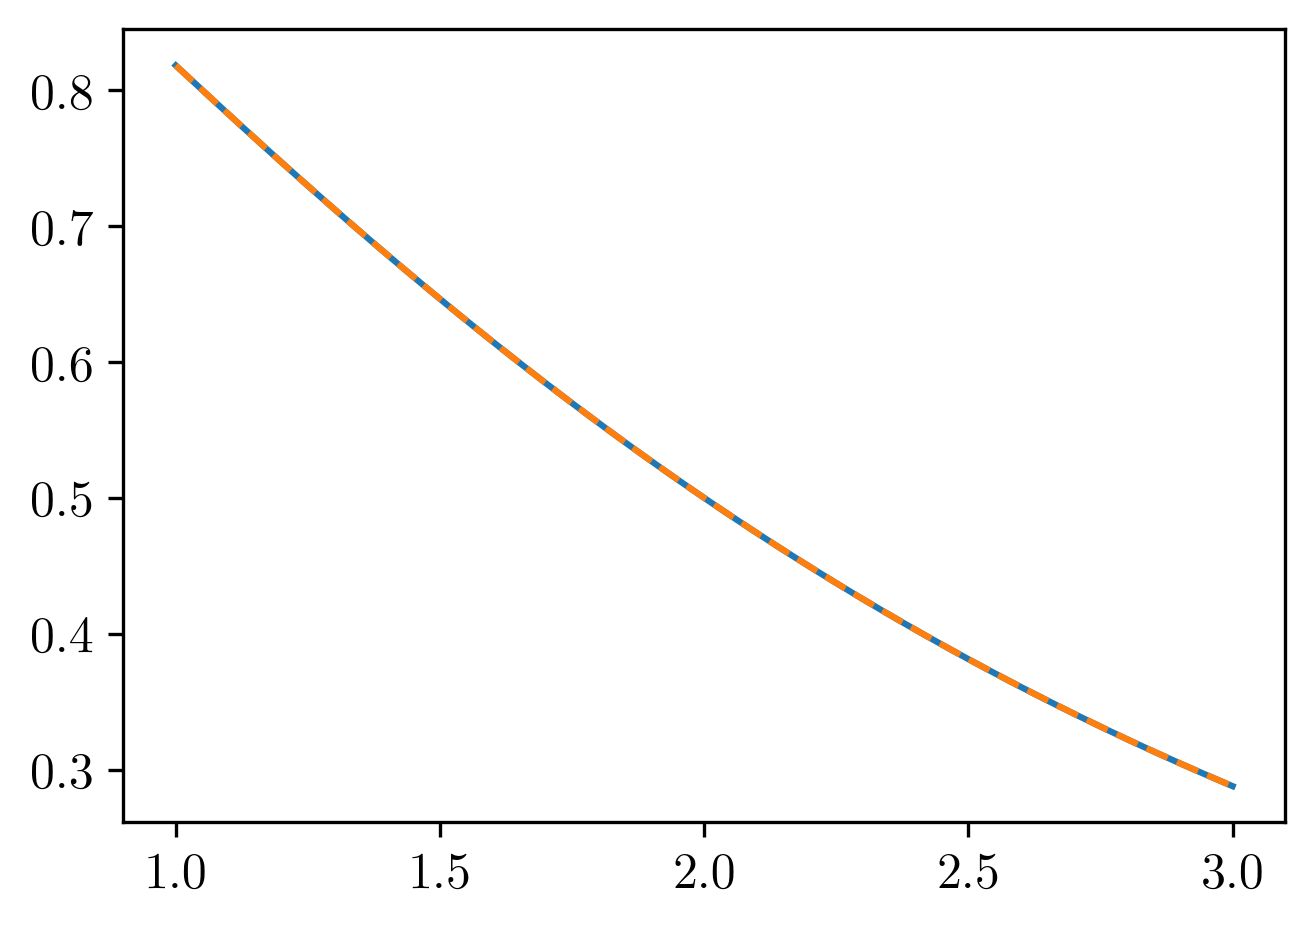

In [23]:
gamma_ss = np.linspace(1., 3., 300)
plt.plot(gamma_ss, betainc(gamma_ss - 1/2, 3/2, 1/2))
plt.plot(gamma_ss, get_xi(torch.tensor(gamma_ss)), "--")

In [30]:
betainc(_gamma_s_vals - 1/2, 3/2, 1/2)

tensor([0.8183, 0.8159, 0.8135, 0.8110, 0.8086, 0.8062, 0.8038, 0.8014, 0.7990,
        0.7966, 0.7942, 0.7918, 0.7894, 0.7870, 0.7846, 0.7822, 0.7798, 0.7775,
        0.7751, 0.7727, 0.7703, 0.7680, 0.7656, 0.7632, 0.7609, 0.7585, 0.7562,
        0.7538, 0.7515, 0.7492, 0.7468, 0.7445, 0.7422, 0.7398, 0.7375, 0.7352,
        0.7329, 0.7306, 0.7283, 0.7260, 0.7237, 0.7214, 0.7191, 0.7168, 0.7145,
        0.7122, 0.7100, 0.7077, 0.7054, 0.7032, 0.7009, 0.6986, 0.6964, 0.6942,
        0.6919, 0.6897, 0.6874, 0.6852, 0.6830, 0.6808, 0.6786, 0.6764, 0.6742,
        0.6720, 0.6698, 0.6676, 0.6654, 0.6632, 0.6610, 0.6588, 0.6567, 0.6545,
        0.6524, 0.6502, 0.6481, 0.6459, 0.6438, 0.6416, 0.6395, 0.6374, 0.6353,
        0.6331, 0.6310, 0.6289, 0.6268, 0.6247, 0.6226, 0.6205, 0.6185, 0.6164,
        0.6143, 0.6122, 0.6102, 0.6081, 0.6061, 0.6040, 0.6020, 0.5999, 0.5979,
        0.5959, 0.5939, 0.5918, 0.5898, 0.5878, 0.5858, 0.5838, 0.5818, 0.5798,
        0.5779, 0.5759, 0.5739, 0.5719, 

In [28]:
_gamma_s_vals = torch.linspace(1., 3., 300)
_betainc_vals = betainc(_gamma_s_vals - 1/2, 3/2, 1/2)

def get_xi(gamma_s):
    return interp(_gamma_s_vals, _betainc_vals, gamma_s.unsqueeze(0))[0]